In [1]:
import time
import numpy as np

# Audio utils

In [2]:
from abc import abstractmethod

In [3]:
class FeatureModule(object):
    
    def __init__(self, sample_rate, hop_length, num_channels=1, decibels=True):
        self.sample_rate = sample_rate
        self.hop_length = hop_length
        self.num_channels = num_channels
        self.decibels = decibels
        
    def get_expected_frames(self, audio):
         # Simply the number of hops plus one
        num_frames = 1 + len(audio) // self.hop_length
        return num_frames
    
    def get_sample_range(self, num_frames):
         # Calculate the boundaries
        max_samples = num_frames * self.hop_length - 1
        min_samples = max(1, max_samples - self.hop_length + 1)

        # Construct an array ranging between the minimum and maximum number of samples
        sample_range = np.arange(min_samples, max_samples + 1)
        return sample_range
    
    @abstractmethod
    def process_audio(self, audio):
        return NotImplementedError
    
    def to_decibels(self, feats):
        feats = librosa.core.amplitude_to_db(feats, ref=np.max)
        return feats

    def post_proc(self, feats):
        if self.decibels:
            # Convert to decibels (dB)
            feats = self.to_decibels(feats)

            # TODO - make additional variable for 0/1 scaling
            # Assuming range of -80 to 0 dB, scale between 0 and 1
            feats = feats / 80
            feats = feats + 1
        else:
            # TODO - should anything be done here? - would I ever not want decibels?
            pass

        # Add a channel dimension
        feats = np.expand_dims(feats, axis=0)
        return feats
    
    def get_times(self, audio):
        num_frames = self.get_expected_frames(audio)

        frame_idcs = np.arange(num_frames + 1)
        # Obtain the time of the first sample of each frame
        times = librosa.frames_to_time(frames=frame_idcs,
                                       sr=self.sample_rate,
                                       hop_length=self.hop_length)
        return times
    
    def get_sample_rate(self):
        sample_rate = self.sample_rate
        return sample_rate

    def get_hop_length(self):
        hop_length = self.hop_length
        return hop_length

    def get_num_channels(self):
        num_channels = self.num_channels
        return num_channels

    @classmethod
    def features_name(cls):
         return cls.__name__

## patch madmom import error with sed

In [4]:
from madmom.audio.signal import SignalProcessor, FramedSignalProcessor
from madmom.audio.stft import ShortTimeFourierTransformProcessor
from madmom.audio.spectrogram import (
    FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor,
    SpectrogramDifferenceProcessor)
from madmom.processors import ParallelProcessor, SequentialProcessor

In [5]:
class LOG_SPECT(FeatureModule):
    def __init__(self, num_channels=1, sample_rate=22050, win_length=2048, hop_size=512, n_bands=[12], mode='online'):
        sig = SignalProcessor(num_channels=num_channels, win_length=win_length, sample_rate=sample_rate)
        self.sample_rate = sample_rate
        self.hop_length = hop_size
        self.num_channels = num_channels
        multi = ParallelProcessor([])
        frame_sizes = [win_length]  
        num_bands = n_bands  
        for frame_size, num_bands in zip(frame_sizes, num_bands):
            if mode == 'online' or mode == 'offline':
                frames = FramedSignalProcessor(frame_size=frame_size, hop_size=hop_size) 
            else:   # for real-time and streaming modes 
                frames = FramedSignalProcessor(frame_size=frame_size, hop_size=hop_size, num_frames=4) 
            stft = ShortTimeFourierTransformProcessor()  # caching FFT window
            filt = FilteredSpectrogramProcessor(
                num_bands=num_bands, fmin=30, fmax=17000, norm_filters=True)
            spec = LogarithmicSpectrogramProcessor(mul=1, add=1)
            diff = SpectrogramDifferenceProcessor(
                diff_ratio=0.5, positive_diffs=True, stack_diffs=np.hstack)
            # process each frame size with spec and diff sequentially
            multi.append(SequentialProcessor((frames, stft, filt, spec, diff)))
        # stack the features and processes everything sequentially
        self.pipe = SequentialProcessor((sig, multi, np.hstack))

    def process_audio(self, audio):
        feats = self.pipe(audio)
        return feats.T

# Beatmap utils

In [6]:
import re
import os
import torch
import math
import scipy.io.wavfile as wav
import subprocess

In [7]:
class Beatmap():    
    
    def __init__(self, beatmap_dir, beatmap, proc, sample_rate=22050, tmp='./wav/', 
                 peak_type='gaussian', hop_size=512, width=4, ):
        self.beatmap = beatmap
        self.beatmap_dir = beatmap_dir
        self.sample_rate = sample_rate
        self.proc = proc
        self.tmp = tmp
        self.wavf = None
        self.audiof = None
        self.rate = int(sample_rate / hop_size)
        self.w = width
    
        self.timestamp = []
        self.beat_len = []
        self.BeatDivisor = None
        self.frames = None # [data]
        self.beats = None # [gt]
        self.downs = None
        self.m = None # [metadata]
        
        peaks = {
            'gaussian': self.create_gaussian_peak, 
            'linear': self.create_linear_peak, 
            'parabolic': self.create_parabolic_peak
        }
        self.create_peak = peaks[peak_type]
        
    def parse_audiof(self):
        f = open(os.path.join(self.beatmap_dir, self.beatmap))
        for l in f:
            if re.match(r'AudioFilename.*', l):
                self.audiof = re.search('AudioFilename:\s*(.*)', l).group(1)
        f.close()
        
        if not os.path.exists(self.audiof):
            for f in os.listdir(self.beatmap_dir):
                if re.match(self.audiof, f, flags=re.IGNORECASE):
                    self.audiof = f
        
    def get_audiof(self):
        if self.audiof == None:
            self.parse_audiof()
        return self.audiof
        
    def parse_ids(self):
        f = open(os.path.join(self.beatmap_dir, self.beatmap))
        for l in f:
            if re.match(r'BeatmapID.*',  l):
                self.BeatmapID = re.search('BeatmapID:\s*(\d+).*', l).group(1)
            if re.match(r'BeatmapSetID.*', l):
                self.eatmapSetID = re.search('BeatmapSetID:\s*(\d+).*', l).group(1)
        if 'BeatmapSetID' not in locals():
            self.BeatmapSetID = self.beatmap_dir.split('/')[-1].split(' ')[0]
        if 'BeatmapID' not in locals():
            self.BeatmapID = self.beatmap_dir.split('/')[-1].split(' ')[0]
        f.close()
            
    def parse_wav(self):
        self.parse_ids();
        self.wavf = str(self.BeatmapSetID) + '-' + str(self.BeatmapID) + '.wav'
        
    def create_wav(self):
        self.parse_wav()
        mp3 = os.path.join(self.beatmap_dir, self.get_audiof())
        wav = os.path.join(self.tmp, self.wavf)
        subprocess.call(['ffmpeg', '-hide_banner', '-loglevel', 'error', '-y', 
                         '-i', mp3, '-ar', str(self.sample_rate), wav])
        
    def get_wav(self):
        if self.wavf == None:
            self.parse_wav()
            if not os.path.exists(os.path.join(self.tmp, self.wavf)):
                self.create_wav()
        return self.wavf
                
    def parse_beatmap(self):
        rate, audio_data = wav.read(os.path.join(self.tmp, self.get_wav()))
        audio_len = np.shape(audio_data)[0]
        f = open(os.path.join(self.beatmap_dir, self.beatmap))
        
        for l in f:
            if re.match(r'BeatDivisor.*', l):
                self.BeatDivisor = re.search('BeatDivisor:\s*(\d+).*', l).group(1)
                self.BeatDivisor = int(self.BeatDivisor)
                break
        for l in f:
            if re.match(r'\[TimingPoints\]', l):
                break
        for l in f:
            if l == "\n":
                break
            a = l.split(',')
            if float(a[1]) < 0:
                continue
            self.beat_len.append(float(a[1]))
            self.timestamp.append(float(a[0])) 
        self.timestamp.append(int(audio_len / rate * 1000))
        f.close()
    
    def process_audio(self):
        feats = self.proc.process_audio(os.path.join(self.beatmap_dir, self.get_audiof()))
        feats = torch.tensor(feats)
        self.frames = torch.transpose(feats, 0, 1)
        
    def create_gaussian_peak(self, y, i):
        alen = len(y)
        w = self.w/2/2
        
        def func(x):
            return math.exp(-j**2/w**2)
        
        j = 0 
        while i+j > 0 and abs(j) <= w*2:
            f = func(j)
            y[i+j] = max(y[i+j], f, 0)
            j -= 1
        j = 0
        while i+j < alen and abs(j) <= w*2:
            f = func(j)
            y[i+j] = max(y[i+j], f, 0)
            j += 1
            
    def create_parabolic_peak(self, y, i):
        alen = len(y)
        limit = self.w*2
        w = self.w

        def func(x):
            return -(1/w**2 * x**2) + 1

        j = 0        
        while i+j > 0 and abs(j) <= limit:
            f = func(j)
            y[i+j] = max(y[i+j], f, 0)
            j -= 1
        j = 0
        while i+j < alen and abs(j) <= limit:
            f = func(j)
            y[i+j] = max(y[i+j], f, 0)
            j += 1
            
    def create_linear_peak(self, y, i):
        alen = len(y)
        w = self.w/2
        m = 1/w
        limit = w
        
        def func(x):
            return m*x + 1
        
        j=0
        while i+j > 0 and abs(j) <= limit:
            f = func(j)
            y[i+j] = max(y[i+j], f, 0)
            j -= 1
        m = -m
        j = 0
        while i+j < alen and abs(j) <= limit:
            f = func(j)
            y[i+j] = max(y[i+j], f, 0)
            j += 1  
    
    def process_beats(self):
        if len(self.timestamp) == 0:
            self.parse_beatmap()
        self.beats = np.zeros(math.ceil(self.timestamp[-1] * 0.001 * self.rate), dtype=np.float32)
        self.downs = np.zeros(math.ceil(self.timestamp[-1] * 0.001 * self.rate), dtype=np.float32)
        
        d = 0
        i = self.timestamp[0] * 0.001 * self.rate
        while i > 0:
            x = round(i)
            self.create_peak(self.beats, x)
            if d % self.BeatDivisor == 0:
                self.create_peak(self.downs, x)
            i -= self.beat_len[0] * 0.001 * self.rate
            d -= 1
        
        for j in range(len(self.timestamp) - 1):
            i = self.timestamp[j] * 0.001 * self.rate
            d = 0
            while i < (self.timestamp[j+1] * 0.001 * self.rate):
                x = round(i)
                self.create_peak(self.beats, x)
                if d % self.BeatDivisor == 0:
                    self.create_peak(self.downs, x)
                i += self.beat_len[j] * 0.001 * self.rate
                d += 1
            if i >= self.timestamp[-1] * 0.001 * self.rate:
                break
                    
    def get_audio(self):
        if self.frames == None:
            self.process_audio()
        return self.frames
    
    def get_beats(self):
        if self.beats == None:
            self.process_beats()
        return torch.tensor(np.stack((self.beats, self.downs), axis=1))
    
    def get_metadata(self):
        if self.BeatDivisor == None:
            self.parse_beatmap()
        return (self.beatmap, self.rate, self.BeatDivisor)
    
    def get_timings(self):
        if len(self.timestamp) == 0:
            self.parse_beatmap()
        return list(zip(self.timestamp, self.beat_len))

# Dataset

In [8]:
import glob
import copy
import gc
import concurrent.futures
import traceback
import torch
from torch.utils.data import Dataset

In [9]:
class Beatmap_Dataset(Dataset):  
    
    def __init__(self, beatmap_dir, proc, seq_dur=10, sample_rate=22050, hop_size=512, width=4, 
                 peak_type='gaussian', threads=4, threading=True):
        self.beatmap_dir = beatmap_dir
        self.proc = proc
        self.sample_rate = sample_rate
        self.hop_size = hop_size
        self.beatmaps = []
        self.seq_len = int(seq_dur * sample_rate / hop_size)
        self.width = width
        
        if beatmap_dir == None:
            self.x = []
            self.y = []
            self.m = []
            return
        
        j = 0
        for r, dirs, _ in os.walk(beatmap_dir):
            for dir in dirs:
                for root, _, files in os.walk(os.path.join(r, dir)):
                    for f in files:
                        if re.match('.*.osu$', f):
                            self.beatmaps.append(Beatmap(root, f, proc, sample_rate=sample_rate, 
                                                         hop_size=hop_size, width=width, peak_type=peak_type))
                            j += 1
                                            
        self.x = [None] * j
        self.y = [None] * j
        self.t = [None] * j
        self.m = [None] * j

        def process(i):
            m = self.beatmaps[i]
            self.beatmaps[i] = None
            try:
                print(str(i) + '/' + str(j-1), m.beatmap)            
                self.x[i] = copy.deepcopy(m.get_audio())
                self.y[i] = copy.deepcopy(m.get_beats())
                self.t[i] = copy.deepcopy(m.get_timings())
                self.m[i] = copy.deepcopy(m.get_metadata())
            except Exception as e:
                traceback.print_exc()
                print("pruning:", m.beatmap)     
                self.x[i] = None
                self.y[i] = None
                self.t[i] = None
                self.m[i] = None
            del m
            gc.collect()

        if threading:
            executor = concurrent.futures.ThreadPoolExecutor(threads)
            list(executor.map(process, range(j)))
        else:
            list(map(process, range(j)))
                        
        self.beatmaps = list(filter(None, self.beatmaps))
        self.x = list(filter(lambda x: x != None, self.x))
        self.y = list(filter(lambda x: x != None, self.y))
        self.t = list(filter(None, self.t))
        self.m = list(filter(None, self.m))
        
    def take(self, ds, i, j):
        self.x = ds.x[i:j]
        self.y = ds.y[i:j]
        self.m = ds.m[i:j]
        self.t = ds.t[i:j]
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        if self.seq_len == 0:
            return self.x[i], self.y[i], self.j[i]
        j = np.random.randint(0, self.y[i].shape[0] - self.seq_len)
        return self.x[i][j: j+self.seq_len], self.y[i][j: j+self.seq_len], self.t[i][0], (self.m[i], i, j)

In [10]:
# debug
log_spect = LOG_SPECT(sample_rate=44100, hop_size=441*2, n_bands=[24], mode='offline')
s = Beatmap_Dataset('../ex/beatmaps', log_spect, sample_rate=44100, hop_size=441*2, width=2, peak_type='linear', threading=True)

0/9 TMABird - Everybody's Circulation (Vncegd) [Very Easy].osu
1/9 TMABird - Everybody's Circulation (Vncegd) [Normal].osu
2/9 3/9 TMABird - Everybody's Circulation (Vncegd) [Easy (new)].osu
TMABird - Everybody's Circulation (Vncegd) [Hard (new)].osu
4/9 TMABird - Everybody's Circulation (Vncegd) [Insane].osu
5/9 TMABird - Everybody's Circulation (Vncegd) [Easy].osu
6/9 TMABird - Everybody's Circulation (Vncegd) [Hard].osu
7/9 TMABird - Everybody's Circulation (Vncegd) [Expert].osu
8/9 TMABird - Everybody's Circulation (Vncegd) [Normal (new)].osu
9/9 LamazeP - Spam Jack (OsuToothbrush) [SPAM].osu


# Constants

In [110]:
sample_rate = 44100
hop_size = 441 * 2
seq_dur = 10
peak_type = 'gaussian'
width = 4

beatmap_dir = '../beatmaps'
ds_path = './datasets/DBN/ds_' + peak_type + '.pkl'
model_path = './models/DBN/model_' + peak_type + '.pt'

# Process Data

In [12]:
start = time.time()

log_spect = LOG_SPECT(sample_rate=sample_rate, hop_size=hop_size, n_bands=[24], mode='offline')
ds = Beatmap_Dataset(beatmap_dir, log_spect, seq_dur=seq_dur, sample_rate=sample_rate, 
                     hop_size=hop_size, peak_type=peak_type, width=width, threads=64, threading=True)

end = time.time()
print(end - start, 'secs')

0/1511 Chata - Engage (Lasse) [Insane].osu
1/1511 Mimi - Surrealism (feat. ZAT) (-Tatsuo) [no mania].osu
2/1511 sana - kanojo wa tabi ni deru (Firika) [Insane].osu
3/1511 Ishida Youko - To the Promised Sky ~The place that I was~ (caren) [Collabo].osu
4/1511 StylipS - Prism Sympathy(Asterisk Remix) (iMage--) [Kaleid Liner].osu
5/1511 Cranky - Chandelier - King (Mao) [Gero's Insane].osu
6/1511 senya - Akatsuki no Suiheisen ni (Satellite) [Zweib's Insane].osu
7/1511 Tadokoro Azusa - 1HOPE SNIPER (Sotarks) [NiNo's Insane].osu
8/1511 fripSide - future gazer (TV Size) (alacat) [Insane].osu
9/1511 cYsmix - bells! (Gero) [normal!].osu
10/1511 Yazawa Nico (CV.Tokui Sora) - Nicopuri Joshidou (yf_bmp) [z1085684963's Insane].osu
11/1511 Hamburgaga - Watame Internet Connection Race (CE6A) [Insane].osu
12/1511 xi - Parousia -LAST JUDGMENT- (Zapy) [Retribution].osu
13/1511 Shiena Nishizawa - Meaning (Taeyang) [xChippy's Insane].osu
14/1511 namirin - Hitokoto no Kyori (sahuang) [Linadeft's Insane].osu

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 176, in process_beats
    if d % self.BeatDivisor == 0:
TypeError: unsupported operand type(s) for %: 'int' and 'NoneType'


102/1511 sasakure.UK x DECO27 - 39 (Finshie) [Insane].osu
103/1511 Chata - len (Cami) [xiqingwa's Lunatic].osu
104/1511 Fractal Dreamers - Fata Morgana (Natsu) [captin's Insane].osu
105/1511 u's - Snow Halation (Asterisk DnB Remix) (jeydude) [Nico].osu
106/1511 Atoguru - Hana no Sadame (CSAQ) [Insane].osu
107/1511 Daisuke Ishiwatari - Condemnation Wings (Jounzan) [Requiem Aeternam].osu
108/1511 gmtn. (witch's slave) - furioso melodia (Urushi38) [EDITED].osu
109/1511110/1511 Warak - Once Upon A Time (Xilver) [UC's Insane].osu
 Gladenfold - ...To Eternity (LMT) [Yamicchi's Light Insane].osu
111/1511 Krewella - Say Goodbye (Nightcore Mix) (Cut Ver.) (Bquntii) [Ignorance].osu
112/1511 Hatsune Miku - Hand in Hand (Magical Mirai ver.) (Aureola) [Normal].osu
113/1511 livetune feat. Hatsune Miku - Hand in Hand (Magical Mirai ver.) (Inversal) [Marathon].osu
114/1511 Hatsuki Yura - Mitsu Matoishi Shiro no Himegimi ~Snow White~ (IceKalt) [Princess' Fury].osu
115/1511 Yoshimura Haruka, Uchida Maay

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 176, in process_beats
    if d % self.BeatDivisor == 0:
TypeError: unsupported operand type(s) for %: 'int' and 'NoneType'


pruning: Gojou Kai - Touhou Youkai Komachi (James) [Normal].osu
119/1511 Tanya Degurechaff (CV Yuki Aoi) - Los! Los! Los! (Logic Agent) [Mun's Insane].osu
120/1511 Hatsuki Yura - Kowaku no Mori (mama2093) [Dance].osu
121/1511 Tama - Sonna Yume wo Mita no ~lonely dreaming girl~ (Remix) (BlackSheep) [It's a Snowy Dream [AR9]].osu
122/1511 Sawai Miku - Colorful. (Asterisk DnB Remix) (Asfand) [Vibrant].osu
123/1511 Yunomi & nicamoq - Indoor Kei Nara Trackmaker (dipperbee) [TrAcK MaKeR].osu
124/1511 GTA feat. Sam Bruno - Red Lips (Mendus Remix) (Euny) [Natsu's Insane].osu
125/1511 TrySail - Utsuroi (Short Ver.) (Log Off Now) [Nexus' Insane].osu
126/1511 ZAQ - Seven Doors (eINess) [wkyik's Insane].osu
127/1511 M2U - Stellar (Ultima Fox) [defiance's Insane].osu
128/1511 SawanoHiroyuki[nZk]mizuki - aLIEz (jonathanlfj) [Trust's Normal].osu
129/1511 YOASOBI - Yoru ni Kakeru (Petal) [Keirelia's Insane].osu
130/1511 Usada Pekora - Discommunication Alien (Yugu) [XLT's Insane].osu
131/1511 EastNewSo

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 39, in process
    self.x[i] = copy.deepcopy(m.get_audio())
  File "/tmp/ipykernel_21672/777479308.py", line 196, in get_audio
    self.process_audio()
  File "/tmp/ipykernel_21672/777479308.py", line 103, in process_audio
    feats = self.proc.process_audio(os.path.join(self.beatmap_dir, self.get_audiof()))
  File "/tmp/ipykernel_21672/680612967.py", line 27, in process_audio
    feats = self.pipe(audio)
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/madmom/processors.py", line 120, in __call__
    return self.process(*args, **kwargs)
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/madmom/processors.py", line 424, in process
    data = _process((processor, data, kwargs))
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/madmom/processors.py", line 289, in _process
    return process_tuple[0](*process_tuple[1:-1], **process_tuple[-1])
  Fi

178/1511 Dark PHOENiX - Taketori Hishou (KanbeKotori) [Extra].osu
179/1511 Mili - Origin (TV Size) (Ryuusei Aika) [kanor's Insane].osu
180/1511 Hanataba - Night of Knights (v2b) [Normal].osu
181/1511 Sagara Kokoro - Hoshizora no Ima (Star Stream) [Insane].osu
182/1511 Hanatan - Uta ni Katachi wa Nai keredo (Asahina Momoko) [Recollection].osu
183/1511 PinocchioP - SLoWMoTIoN (Short Ver.)feat.Hatsune Miku (lllmtklll) [Insane].osu
184/1511 Yoko Takahashi - Zankoku Na Tenshi No These (TV. Size Version) (moph) [Ambient's Insane].osu
185/1511 Noboru ft. Hatsune Miku - Shiroi Yuki No Princess Wa (Hokichi) [ShiraHoki's Light Insane].osu
186/1511 Chitose Sara - Arcadia (Short ver.) (Riven) [-Tochi's Insane].osu
187/1511 eyemedia - Bloody Purity (tsuka) [Normal].osu
188/1511 Atoguru - Itoshi Kimi wo Mitsuke ni (Pizza Kun) [Insane].osu
189/1511 Hanasaka Yui(CV M.A.O) - Harumachi Clover (Naotoshi) [Light Insane].osu
190/1511 Hatsune Miku - Ephemeral (Wishkey) [Fade Away].osu
191/1511 emon - shake 

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 175, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 12646 is out of bounds for axis 0 with size 12646


pruning: Hatsune Miku - World is Mine (tom800510) [Queen!!].osu
223/1511 ginkiha - dawn(ginkiha hardcore remix) (Aka) [Kyubey's Insane].osu


Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 15863 is out of bounds for axis 0 with size 15850


pruning: Hatsuki Yura - Kowaku no Mori (mama2093) [Dance].osu
224/1511 seleP - Remember me (Avishay) [A's Extra].osu
225/1511 Kano - Stella-rium (Kowari) [Insane].osu
226/1511 IOSYS - Hakurei Jinja (tieff) [Normal].osu
227/1511 Meg & Dia - Monster (Nightcore Dubstep Remix) (Milky White) [Collab].osu
228/1511229/1511 mafumafu - Revenge Syndrome (Rizia) [Revenge].osu SuganoMusic - Imademo... (S i R i R u) [Insane].osu

230/1511 Iguchi Yuka - Kakumei Zenya (TV Size) (YukiZura-) [World].osu
231/1511 Petit Rabbit's - Daydream cafe(TV size) (TetMax) [Heart Leap].osu
232/1511 Tsunamaru - Daidai Genome (Lust) [Insane].osu
233/1511 DM Ashura - Classical Insanity (Louis Cyphre) [Vivacissimo].osu
234/1511 a_hisa - Tokei no Heya to Seishin Sekai (Asahina Momoko) [wring's Hyper].osu
235/1511 Ogura Yui - Honey Come!! (TV size) (Sekai-nyan) [Kanto's Insane].osu
236/1511 Kano - Daisy Blue (Fycho) [Insane].osu
237/1511 bbn - Identic Conflict (- Rabbit -) [full version].osu
238/1511 Tsunamaru - paranoia

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 175, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 9546 is out of bounds for axis 0 with size 9546


249/1511 K2 - Karaburi Sadistic (Shinxyn) [Insane].osu


Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 7829 is out of bounds for axis 0 with size 7829


pruning: Warak - REANIMATE (iyasine) [xsrs's Extra].osu
250/1511 251/1511 Mitchie M feat. Hatsune Miku with KAITO - Ohedo Julia-Night (Natsu) [Insane].osu
SYNC.ART'S - Sins -Kokoro no Tsumi- (Snowy Dream) [Nightmare].osu
252/1511 dj TAKA - Elpis (Planecakes) [I cAN STREAM].osu
253/1511 a_hisa - Star Prism (-Amane-) [Refraction].osu
254/1511 MUMEI_ver.SP - Kokoro ga Odoru Herb Tea yoo (- G I D Z -) [Left's Insane].osu
255/1511 Panda Eyes & Teminite - Highscore (Fort) [LGV's Insane].osu
256/1511 yanaginagi - Vidro Moyou (QL Tell Your World Mashup) (- t e n n y a -) [Laurier's Insane].osu
257/1511 MIMI feat. Hatsune Miku - Ai no Sukima (theramdans) [Insane].osu
258/1511 REDALiCE - Bad Apple!! (Rena-chan) [Insane].osu
259/1511 storyteller(cosMo x GAiA) feat. IA, Kagamine Rin - Anti the EuphoriaHOLiC (SaltyLucario) [Nowa's Insane].osu


Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 176, in process_beats
    if d % self.BeatDivisor == 0:
TypeError: unsupported operand type(s) for %: 'int' and 'NoneType'


pruning: IOSYS - Hakurei Jinja (tieff) [Normal].osu
260/1511 Tamura Yukari - Songs Compilation (Milan-) [lolis].osu
261/1511 LeaF - Alice in Misanthrope -Ensei Alice- (eiri-) [Uberzolik's Insane].osu
262/1511 Rita - dorchadas (Delis) [Mirash's Insane].osu
263/1511 Hatsuki Yura - Diabolikha (Lan wings) [Death].osu
264/1511 Miki Sayaka (CV Kitamura Eri), Sakura Kyoko (CV Nonaka Ai) - and I'm home (Kyuukai) [Sayaka].osu
265/1511 seleP - BELHALA (Bara-) [Perpetual Loneliness].osu
266/1511 Hatsuki Yura - Diabolikha (pkuai) [chart with upwards trend].osu
267/1511 DECO 27 feat. Hatsune Miku - Delusion Tax (Bluepurr) [Delusion].osu
268/1511 Jan Wayne Vs. Raindropz - Numb (Nightcore Ver.) (KIA) [SteRRuM's Insane].osu
269/1511 Nanahira - Bassdrop Freaks (Long Ver.) (yf_bmp) [BASSDROP!!].osu
270/1511 Mayama Rika - Liar Mask anime size (Aerous) [captin's Insane].osu
271/1511 Hanatan - RED Signal (Koalazy) [Insane].osu
272/1511 Tsukudani Norio - Atashi no Kamisama (Amateurre) [Shizuku's Insane].osu

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 175, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 4577 is out of bounds for axis 0 with size 4577


pruning: Hatsune Miku - Triple Baka (Mafiamaster) [Insane].osu
369/1511 Various Artists - Ar3's eggpain maps project ([CSGA]Ar3sgice) [unfinished].osu
370/1511 Nightcore - Pinball (jericho2442) [Ultimate's Craziness].osu
371/1511 Kanon Wakeshima - Love your enemies (Delis) [Insane].osu
372/1511 Hatsune Miku - Dou Iu Koto Nano! (Raging Bull) [Insane!].osu
373/1511 M2U - Moon Halo (Minorsonek) [Namki's Insane].osu
374/1511 senya - Hitomi ni Kakusareta Omoi (Satellite) [wring's Hard].osu
375/1511 Ito Kanako - Uncontrollable (TV Size) (Hakura) [LCFC's Insane].osu
376/1511 UNDEAD CORPORATION - Yoru Naku Usagi wa Yume o Miru (Smoothie) [Normal].osu
377/1511 dj TAKA - quaver (Sotarks) [Yukiyo's Insane].osu


Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 11588 is out of bounds for axis 0 with size 11588


378/1511 penoreri - Monochrome and Vivid (Nube) [Awake].osu
pruning: SYNC.ART'S ft. Sakaue Nachi - Green Grass Garden (SENSEABEL) [Extra].osu
379/1511 Sharlo - Eisou Youga ~Meikyou Shisui~ (Sharlo) [FrostxE's Insane].osu
380/1511 HachioujiP feat. Hatsune Miku - take it easy (Seto Kousuke) [Insane].osu
381/1511 PinocchioP - I'm glad you're evil too (Monstrata) [Devious].osu
382/1511 Wisp X - Crimson feat. Hatsune Miku (Radio Edit) (Nao Tomori) [yaspo's insane].osu
383/1511 Aiobahn & Yunomi - Makuramoto Ni Ghost (- Yoshimaro -) [Bounce C].osu
384/1511 Haru - Skygazer (Instrumental) (Mukku) [Yes].osu
385/1511 Ceui - MeltyMoment short.ver (Down) [Left's Light Insane].osu
386/1511 Camellia_feat._Nanahira_-_Can_I_Friend_You_On_Bassbook_Lol_Cranky_Remix_-_Theya_-_Can_I_map_you_an_O.osu
387/1511 Yokomin - Yukari (Shiirn) [from Love to Grief].osu
388/1511 ~DJ YOSHITAKA~ - GalacticFlower (Mazukito) [Sakura].osu
389/1511 M2U - Masquerade (Melt) [Insane].osu
390/1511 ALiCE'S EMOTiON - Dark Flight 

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 7464 is out of bounds for axis 0 with size 7464


pruning: YuugouP - YELLOW TRICK (Noffy) [oko's Insane].osu
577/1511 Ariabl'eyeS - Symmetric Rose (My Angel RangE) [Rosenkreuz].osu
578/1511 Ling Yuan yousa - Hoshi to Kimi ga Kieta Hi (Gaia) [Insane].osu
579/1511 Himeringo - Yuudachi no Ribbon (Kosaki-kun) [Insane].osu
580/1511 Primastella - Koigokoro (Sleeping Soul) [Soul's Pain].osu
581/1511 sasakure.UK - HeavenZ-ArmZ (Raose) [Heaven].osu
582/1511 Sakaue nachi - Think of You (__Ag) [Ag style].osu
583/1511 Hatsune Miku - My Time (illuminist) [Insane].osu
584/1511 Dzeko & Torres - L'Amour Toujours feat. Delaney Jane (Nightcore Mix) (Nuvolina) [Anto's Insane].osu
585/1511 seleP feat. IA ROCKS - ReLief (Bara-) [Fateful Re;2].osu
586/1511 KOKOMI - Seikyou no Igreja (IceKalt) [Insane].osu
587/1511 ryo (supercell) - ODDS&ENDS (marikokkokokko) [Extra].osu
588/1511 IA  ASY - See the Lights (Isrealrc) [Normal].osu589/1511
 Utsu-P - Baby Deathmatch (Net0) [Trynna's Insane].osu
590/1511 xi - ANiMA (liaoxingyao) [Vert's LV.11].osu
591/1511 Gachi 

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 2952 is out of bounds for axis 0 with size 2952


609/1511 Panda Eyes - On My Own (Plaudible) [Yamicchi's Insane].osu
610/1511 Itoki Hana - Wa-cycle- (TV Size) (Kaitjuh) [Crys' Insane].osu
611/1511 Kanon Wakeshima - World's End, Girl's Rondo(Asterisk DnB Remix) (Venax) [My Wish is That You End This World].osu
612/1511 eyelis - Mirai e no Tobira (OVA EDIT) (Bearizm) [Insane].osu
613/1511 Hatsuki Yura - Saramandora no Odoriko (Reimoe) [Insane].osu
614/1511 Ariabl'eyeS - Shuen no kane (My Angel RangE) [Death species].osu
615/1511 Ariabl'eyeS - EDEN (-Shiroki-) [Moeyoken].osu


Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 175, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 7330 is out of bounds for axis 0 with size 7330


pruning: Hatsune Miku - Ievan Polkka (James) [Normal].osu
616/1511 yanaginagi - Tokohana (TV Size) (Sharlo) [Insane].osu
617/1511 LamazeP - Triple Baka (CDFA).osu
618/1511 orangentle  Yu_Asahina - HAELEQUIN (Extended ver.) (Cellina) [Dissociative Identity Disorder].osu
619/1511 Ogura Yui - Honey Come!! (TV size) (Moeka) [Insane].osu
620/1511 Sawai Miku - Colorful. (Asterisk DnB Remix) (Amamiya Yuko) [Megumi].osu
621/1511 S3RL - Catchit (HML) [Neko].osu
622/1511 WALKUERE - Ichido dake no Koi nara (Fumika) [Insane].osu
623/1511 Tokisawa Nao - BRYNHILDR IN THE DARKNESS -Ver.EJECTED- (l______l) [Opacity].osu
624/1511 Omoi - Snow drive - Miku (khaemlx15) [Snow drive].osu
625/1511 Cilvery - Kamisama Nejimaki (sukiNathan) [Insane].osu
626/1511 Camellia - NUCLEAR-STAR (Ora) [FUSION].osu
627/1511 Various Nightcore - Jump Training #2 (rezoons) [We Go Down].osu
628/1511 THE ROLLING GIRLS - Hito ni Yasashiku (Pata-Mon) [Bread's insane].osu
629/1511 Hatsune Miku - Kusaregedou to Chocolate (val0108)

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 175, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 14962 is out of bounds for axis 0 with size 14962


632/1511 Yooh - MariannE (Dab) [Zero].osu
633/1511 Marie - Clover's Day (Nightshiftt) [Kami].osu
634/1511 Wakeshima Kanon - Shoujo Shikake no Libretto ~Storytelling by solita~ (Deramok) [Insane].osu
635/1511 Camellia - dfor the DELTA (Naitoshi) [Contamination].osu
636/1511 yuikonnu - AOI-IRO STEP (Momochikun) [Insane].osu
637/1511 EastNewSound - A Seeping Bloodline, the Prison of Lunacy (Shian-aaa) [Awaken 14].osu
638/1511 Rin - Lunatic set 09 ~ Faraway 380,000-Kilometer Voyage (Mentai) [Embarking on a Lunar Voyage].osu
639/1511 Nico Nico Douga - Battle Against a Dangerous Yoshika (Mafiamaster) [Andrea's Insane].osu
640/1511 Sound Horizon - Raijin no Hidariude (AngelHoney) [Insane].osu


Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 6639 is out of bounds for axis 0 with size 6639


pruning: xi - .357 Magnum (Akali) [Normal].osu
641/1511 Yuki Hayashi - You Say Run (Zare) [Akitoshi's Insane].osu
642/1511 PinocchioP - Kusaregedou to Chocolate (Kenterz9) [sumaru's Insane].osu
643/1511 Pegboard Nerds - Hero (feat. Elizaveta) (Miss Mandii) [No Escape[zs][wip]].osu
644/1511 MISATO - Necro Fantasia (Chromoxx) [Lasse's Lunatic].osu
645/1511 a_hisa - Anhedonia (warabi) [Ambient].osu
646/1511 EGOIST - Lovely Icecream Princess Sweetie (Toshima) [Insane].osu
647/1511 KOTOKO - Unfinished (Kizuno) [Accelerated].osu
648/1511 Lily - Chloe (Kochiya Sanae) [Snow].osu
649/1511 ClariS - Hitorigoto -TV MIX- (Tofu1222) [kanor's Insane].osu
650/1511 ClariS - CLICK (TV Size) (KantoKun) [Regou's Insane].osu
651/1511 Roselia - ETERNAL BLAZE (Atalanta) [Limitless Future].osu
652/1511 Blend A - Bon Appetit S (TV Size ver) (Hey lululu) [Insane].osu
653/1511 Laur - Pristine (J1_) [Viola].osu
654/1511 Sagittarius - Raise the FLAG (Asuka_-) [gary00737's Insane].osu
655/1511 May'n - Belief (Kibbl

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 16830 is out of bounds for axis 0 with size 16830


pruning: ryo (supercell) - ODDS&ENDS (marikokkokokko) [Extra].osu
695/1511 yuiko - Kimi to Yumemishi (Down) [BetaStar's Insane].osu
696/1511 Yooh - Dynasty -da capo- (10nya) [Descendant].osu
697/1511 orangentle - HAELEQUIN (Gamu) [toybot's Insane].osu
698/1511 Shimotsuki Haruka - small star (ImpurePug) [Lasse's Insane].osu
699/1511 Sengoku Nadeko (CV Hanazawa Kana) - Mousou Express (semaphore) [semamity's Collab Insane].osu
700/1511 Yu-Peng Chen @HOYO-MiX - A Sweet Smile ([Arc]) [Insane].osu
701/1511 Nekomata Master - Avalon no Oka (moph) [Insane].osu
702/1511 Tanya Degurechaff (CV. Aoi Yuuki) - Los! Los! Los! (ChronoNig) [TheOnlyLeon's Hard].osu
703/1511 ZUN - Lunatic Eyes ~ Invisible Full Moon (Leader) [Yoeri's Hard].osu
704/1511 Memme - Extreme Fantasy (Ekoro) [TAG8].osu
705/1511 NightcoreFC - Nightcore - Cold as ice (Gologle) [Insane].osu
706/1511 Loki - Interlude (Chewin) [Insane].osu
707/1511 ryo (supercell) feat. Hatsune Miku - Sekiranun Graffiti (Colin Hou) [Insane].osu
708/151

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 17445 is out of bounds for axis 0 with size 17445


pruning: MISATO - Necro Fantasia (Chromoxx) [Lasse's Lunatic].osu
748/1511 749/1511fhana - Sorairo Picture (Sotarks) [Haruto's Insane].osu
 Hatsuki Yura - HAMELN (karenying) [Insane].osu
750/1511 Sharlo & Sabbo - Sakura no Hana ga Maiochiru Toki (Wing My Way) [117's Insane].osu
751/1511 iyuna - Emukko Kyun Kyun (cRyo[iceeicee]) [Insane].osu
752/1511 Shimotsuki Haruka - Hidra Heteromycin (Lasse) [Hymn].osu
753/1511 Teto - Kasane Teto Fukkireta (Flamestorm123) [CRAZY!!!].osu
754/1511 mikitoP - 1, 2 Fan Club (Chewin) [Insane].osu
755/1511 nmk - sola (Morinaga) [Insane].osu
756/1511 Rameses B - Flaklypa (-kevincela-) [Insane].osu
757/1511 Tianshi - Alice (Kecco) [Normal].osu
758/1511 Atoguru & Mai Kotoge - VaizravaNa (Natsume) [Insane].osu
759/1511 dark and more dark. - fivehours-Deorro (jskak1) [Insane].osu
760/1511 Nhato - Ibuki (Alheak) [Second Wind].osu
761/1511 ryo (supercell) feat.Hatsune Miku - ODDS&ENDS(dj-Jo Dnb Remix) (AIR) [Easy].osu
762/1511 Sawai Miku - Colorful. (Asterisk DnB

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 7230 is out of bounds for axis 0 with size 7230


pruning: nmk - sola (Morinaga) [Insane].osu
798/1511 ShikiP - Shiki Tokiuta (kanpakyin) [Insane].osu
799/1511 Hatsune Miku - Senbonzakura (Short Ver.) (NatsumeRin) [eveless].osu
800/1511 Yuko Hoshina - Alice in Wonder Halloween (dekutai) [Insane].osu
pruning: Yuko Hoshina - Alice in Wonder Halloween (dekutai) [Insane].osu
801/1511 bibuko - Reizouko Mitara Pudding ga Nai (DeRandom Otaku) [KittySpecial's Insane].osu


Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 39, in process
    self.x[i] = copy.deepcopy(m.get_audio())
  File "/tmp/ipykernel_21672/777479308.py", line 196, in get_audio
    self.process_audio()
  File "/tmp/ipykernel_21672/777479308.py", line 103, in process_audio
    feats = self.proc.process_audio(os.path.join(self.beatmap_dir, self.get_audiof()))
  File "/tmp/ipykernel_21672/777479308.py", line 44, in get_audiof
    self.parse_audiof()
  File "/tmp/ipykernel_21672/777479308.py", line 39, in parse_audiof
    if re.match(self.audiof, f, flags=re.IGNORECASE):
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/re.py", line 190, in match
    return _compile(pattern, flags).match(string)
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/re.py", line 303, in _compile
    p = sre_compile.compile(pattern, flags)
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/sre_compile.py", line 764, in compile
    p = sre_parse.parse(p, flags)
 

802/1511 Plasmagica - Seishun wa Non-Stop! (Asterisk DnB Remix) (chucentry) [=A=].osu
803/1511 bbn - Identic Conflict (soretun) [Extra].osu
804/1511 Bernd Krueger - Sonata No.14 in cis-Moll, Op. 272 - 3. Satz (Fenza) [Presto Agitato].osu
805/1511 Hatsuki Yura - Diabolikha (AlReev) [aaaaaaaaaaa].osu
806/1511 Lime - Renai Syndrome (Cheri) [Insane].osu
807/1511 FELT - Puppet in the Dark (Part I & II) (ailv) [Marionette].osu
808/1511 809/1511PINK GUY - Sekkusu Daisuki (abuZ) [Ecchi].osu Sengoku Nadeko (CV Hanazawa Kana) - Mousou Express (TV size) (Bariton) [Komore's Insane].osu

810/1511 Tia - The Glory Days (Nara) [P A N's Insane].osu
811/1511 Gachi - Bockey Mouse Mash (snezni) [how  to maping ].osu
812/1511 petit milady - Hakone Hakoiri Musume (Lami) [Kalibe's Insane].osu
813/1511 Atoguru - To the Limit (Heatherfield) [TRaSH].osu
814/1511 Houshou Marine with Holoism Fantasy - HoihoiGensou Holoism (Amateurre) [Shizurre's Extra Stage].osu
815/1511 Nishi Asuka - Hajimari Iro Splash (Asteris

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 16830 is out of bounds for axis 0 with size 16830


pruning: ryo (supercell) - ODDS&ENDS (Colin Hou) [Insane].osu
929/1511 Kalafina - Kimi no Gin no Niwa (Hollow Wings) [Insane].osu
930/1511 cYsmix feat. Emmy - Tear Rain (Sun Rainbow) [Insane].osu
931/1511 Junky x Hiiragi Yuka - Happy Halloween (neonat) [Insane].osu
932/1511 DiGiTAL WiNG - Land of Snow & Little Traveler (Pulse) [Forever].osu
933/1511 Shimotsuki Haruka - ReCall (imoutosan) [ReCollab].osu
934/1511 DaniwellP - Nekomimi Switch ([Y o s h i n o]) [Insane].osu
935/1511 Hatsuki Yura - Shoujo to Ougonryuu no Monogatari (terametis) [Insane].osu
936/1511 yanaginagi - Yukitoki (Asterisk DnB remix) (shadow_neko) [Amorous].osu
937/1511 Reol - Asymmetry (Gaia) [Kibboo's Insane].osu
938/1511 Hatsune Miku - Gimmie Gimmie (SkyFlame) [Desire].osu
939/1511 Nitta Emi - White Eternity (Soleily & Epsilon Remix) (Nathan) [Yuuki].osu
940/1511 Ito Kanako - Fatima (TV Size) (Ohwow) [LMT's Insane].osu
941/1511 ClariS - Anemone -TV MIX- (xxdeathx) [wkyik's Insane].osu
942/1511 sweet ARMS - Trust in

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 15650 is out of bounds for axis 0 with size 15650


949/1511 Hatsune Miku - Homework Crisis (val0108) [Insane].osu
950/1511 Yellow Zebra - Hyouketsu Musume (S i R i R u) [Normal].osu
951/1511 seleP - Blood Error (popner) [Blood].osu
952/1511 EastNewSound - ENG Dream (GluRay) [The Dream].osu
953/1511 Shimotsuki Haruka - Youka to Yumeutsutsu (Naitoshi) [Awakening].osu
954/1511 yuikonnu - Yume Chizu (Tari) [captin's Insane].osu
955/1511 Dark PHOENiX - Stirring an Autumn Moon (_lolipop) [Stirring Moon].osu
956/1511 False&Trues - Snow Style (rEdo) [Normal].osu
957/1511 sasakure.UK - ChRoNiClESeVeN feat. Annabel (AIR) [Insane].osu
958/1511 Horie Yui - Asymmetry (Regraz) [fish39's Light Insane].osu
959/1511 S.S.H. - The Decisive Battle with the Fugitives (sjoy) [wkyik's Insane].osu
960/1511 Hatsune Miku - Tell Your World (zKuriyamaMiraiz) [Insane].osu
961/1511 Kagamine Rin and Len - Migikata no Chou (Clement) [H-boy's Insane].osu
962/1511 supercell - Hoshi ga Matataku Konna Yoru ni ([Teichan]) [Sharlo's Insane].osu
963/1511 Nomizu Iori - Black

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 39, in process
    self.x[i] = copy.deepcopy(m.get_audio())
  File "/tmp/ipykernel_21672/777479308.py", line 196, in get_audio
    self.process_audio()
  File "/tmp/ipykernel_21672/777479308.py", line 103, in process_audio
    feats = self.proc.process_audio(os.path.join(self.beatmap_dir, self.get_audiof()))
  File "/tmp/ipykernel_21672/680612967.py", line 27, in process_audio
    feats = self.pipe(audio)
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/madmom/processors.py", line 120, in __call__
    return self.process(*args, **kwargs)
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/madmom/processors.py", line 424, in process
    data = _process((processor, data, kwargs))
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/madmom/processors.py", line 289, in _process
    return process_tuple[0](*process_tuple[1:-1], **process_tuple[-1])
  Fi

991/1511 xi - ANiMA (1112deng) [ExPeRT lv.13].osu
992/1511 Eir Aoi - Cynthia No Hikari (Shad0w1and) [Kencho's Insane].osu
993/1511 Megpoid GUMI & Megurine Luka - Speed (val0108) [Speed].osu
994/1511 Fractal Dreamers - Celestial Horizon (Pho) [Insane Collab].osu
995/1511 ClariS - Colorful -movie MIX- (KantoKun) [Lost's Insane].osu
996/1511 mafumafu - Heart no Atoaji (Left) [sahuang's Insane].osu
997/1511 Shimotsuki Haruka - Liblume (Lasse) [Expert].osu
998/1511 Hatsune Miku - Aka Hinoha (Al-Azif) [Hard].osu
999/1511 supercell feat. Hatsune Miku - BLACK ROCK SHOOTER (-Nya-) [Milan-'s Insane].osu
pruning: supercell feat. Hatsune Miku - BLACK ROCK SHOOTER (-Nya-) [Milan-'s Insane].osu
1000/1511 Komiya Mao - (can you) understand me (Sotarks) [kalibe's insane].osu


Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 39, in process
    self.x[i] = copy.deepcopy(m.get_audio())
  File "/tmp/ipykernel_21672/777479308.py", line 196, in get_audio
    self.process_audio()
  File "/tmp/ipykernel_21672/777479308.py", line 103, in process_audio
    feats = self.proc.process_audio(os.path.join(self.beatmap_dir, self.get_audiof()))
  File "/tmp/ipykernel_21672/777479308.py", line 44, in get_audiof
    self.parse_audiof()
  File "/tmp/ipykernel_21672/777479308.py", line 39, in parse_audiof
    if re.match(self.audiof, f, flags=re.IGNORECASE):
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/re.py", line 190, in match
    return _compile(pattern, flags).match(string)
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/re.py", line 303, in _compile
    p = sre_compile.compile(pattern, flags)
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/sre_compile.py", line 764, in compile
    p = sre_parse.parse(p, flags)
 

1001/1511 REOL - YoiYoi Kokon (Ongaku) [MrSergio's Insane].osu
1002/1511 Yura Hatsuki - Shadows ~Kage Iro Yousei Ehon~ (Sakurauchi Riko) [Normal].osu
1003/1511 Ogura Yui - Honey Come!! (Rizia) [Neria's Insane].osu
1004/1511 Hatsuki Yura - Shoujo to Ougonryuu no Monogatari (Garden) [Collab Insane].osu
1005/1511 fourfolium - SAKURA Skip (Boruma) [Insane].osu
1006/15111007/1511  Miho Arakawa - Inochi no Karakuri (Toshino Kyoko) [The Queen].osu
chano & 40mP - Natsukoi Hanabi (Riven) [N a s y a's Insane].osu
1008/1511 ELISA connect EFP - EONIAN -eonian- (ZZHBOY) [Expelled].osu
1009/1511 TrySail - adrenaline!!! -TV Ver- (Left) [Linada's Insane].osu
1010/1511 KOTOKO - One Small Step (Akitoshi) [Kalibe's Insane].osu
1011/1511 a_hisa - Pastel Subliminal (Albatro) [Insane].osu
1012/1511 Shoujo Fractal - Hatenaki Kaze no Kiseki sae (-Mo-) [Normal].osu
1013/1511 seleP - Blood Error (gaten) [Insane].osu
1014/1511 Quynh Nhu - Don Coi (Instrumental) (- Rabbit -) [Insane].osu
1015/1511 seleP feat. MAY

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 39, in process
    self.x[i] = copy.deepcopy(m.get_audio())
  File "/tmp/ipykernel_21672/777479308.py", line 196, in get_audio
    self.process_audio()
  File "/tmp/ipykernel_21672/777479308.py", line 103, in process_audio
    feats = self.proc.process_audio(os.path.join(self.beatmap_dir, self.get_audiof()))
  File "/tmp/ipykernel_21672/777479308.py", line 44, in get_audiof
    self.parse_audiof()
  File "/tmp/ipykernel_21672/777479308.py", line 39, in parse_audiof
    if re.match(self.audiof, f, flags=re.IGNORECASE):
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/re.py", line 190, in match
    return _compile(pattern, flags).match(string)
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/re.py", line 303, in _compile
    p = sre_compile.compile(pattern, flags)
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/sre_compile.py", line 764, in compile
    p = sre_parse.parse(p, flags)
 

1046/1511 S3RL - Catchit (Radio Edit) (Rolniczy) [Insane].osu
1047/1511 Shikata Akiko - EXEC_CHRONICLE=KEY. (Mir) [Shurelia's Hard].osu
1048/1511 Ice - Parodia Sonatina -Grande- (celerih) [Prelude].osu
1049/1511 Mutsuhiko Izumi - Red Goose (nold_1702) [eikka Medium].osu
1050/1511 ClariS - Luminous (CloudSplash16) [Insane].osu
1051/1511 Cysmix feat. Emmy - Tear Rain (Usubiki) [Insane].osu
1052/1511 Rie Kugimiya, Eri Kitamura & Yui Horie - Pre-Parade (TV Size) (Weezy) [Gladi's Taiga-Insane].osu
1053/1511 yanaginagi - Tokohana (TV Size) (xChippy) [captin's Insane].osu
1054/1511 Casandra - Freaks Romanticism (Ohwow) [Insane].osu
1055/1511 fourfolium - SAKURA Skip (Doormat) [Sekai's Insane].osu
1056/1511 ClariS - PRIMALove -TV Mix- (NeonLights) [ailv's Insane].osu
1057/1511 REOL - YoiYoi Kokon (Pho) [Drop's Insane].osu
1058/1511 HSP feat. Hatsune Miku - Scapecoat (Skyanide) [wub].osu
1059/1511 umu. - Dareka no Shinzou ni Nareta Nara (xbopost) [Collab Insane].osu
1060/1511 501st Joint Fighte

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 12002 is out of bounds for axis 0 with size 12002


pruning: YUC'e - Cinderella Syndrome (Kibbleru) [Insane].osu
1073/1511 Yuki Yumeno - Minority (ArThasCD) [Light Insane].osu
1074/1511 Nitta Emi - White Eternity (Sellenite) [-Yuzuriha's Insane].osu
1075/1511 Sena Wataru feat. sana - Hitori Tabi (Smug Nanachi) [Solo Trip].osu
1076/1511 Petit Rabbit's - No Poi! (nenpulse bootleg remix) (Skystar) [Rizia's Insane].osu
1077/1511 Mutsuhiko Izumi - Snow Goose (wmfchris) [ignore's Insane].osu
1078/1511 Niko - Night of Fire (Gabi) [Insane].osu
1079/1511 Luschka - unravel (Mirash) [Insane].osu
1080/1511 ChouCho - Ashita no Kimi sae Ireba Ii. (Karia) [Megtoshi's Insane].osu
1081/1511 wowaka - Hatsune Miku - Two-Faced Lovers ([ R e i m u ]) [Insane].osu


Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 175, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 12500 is out of bounds for axis 0 with size 12500


pruning: Hatsune Miku - Aka Hinoha (Al-Azif) [Hard].osu
1082/1511 Hanasaka Yui(CV M.A.O) - Harumachi Clover (Djulus) [Masha's Insane].osu
1083/1511 CON - Cruel Clocks (Amamiya Yuko) [TuEasy].osu1084/1511
 Mili - Rightfully (enryotoki) [To Reclaim What Was Once Rightfully Ours.].osu
1085/1511 EYEMEDIA - HOLY KNIGHT (snowsign7) [Insane].osu
1086/1511 Mitsuki Kotono - Fuyu ni Saku Hana (Garden) [Insane].osu
1087/1511 Wakeshima Kanon - Foul Play ni Kurari (TV Size) (Uta) [AncuL's Insane].osu
1088/1511 Nanawo Akari - One Room Sugar Life (Fushimi Rio) [Gust's Insane].osu
1089/1511 Lily - Scarlet Rose (val0108) [0108 style].osu
1090/1511 Hatsune Miku - Sakura Zensen Ijou Nashi (Lalarun) [Normal].osu
1091/1511 Chito (CV Minase Inori), Yuuri (CV Kubo Yurika) - More One Night (Assertive Hardcore Bootleg) (Minorsonek) [diuS' Insane].osu
1092/1511 Hatsune Miku - Rolling Girl (Saturio) [Sharon's].osu
1093/1511 kamome sano - starlights feat. TEA (RepL4y) [Glorious].osu
1094/1511 Innocent Key - Lunat

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 11443 is out of bounds for axis 0 with size 11443


pruning: senya - Koyoi Index (jonathanlfj) [Railgun's Easy].osu
1101/1511 Krewella - Say Goodbye (PantyDev) [Normal].osu
1102/1511 OkameP (Hatsune Miku) - You're not Alone (- Aoi Nagisa-) [Solitude].osu
1103/1511 Asaka - I believe what you said (TV Size) (Okoratu) [Spkz's Insane].osu
1104/1511 S-C-U feat. Qrispy Joybox - anemone (Irreversible) [Fang's Insane].osu
1105/1511 senya - Zouka de Arou to Shita Mono (AtHeoN) [Satellite].osu


Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 14604 is out of bounds for axis 0 with size 14604


pruning: seleP - Blood Error (gaten) [Insane].osu
1106/15111107/1511 Yuyoyuppe - Hidamari no Uta (Seto Kousuke) [Expert].osu Halozy - Secret Sister Complex (moonlightleaf) [Flandre].osu

1108/1511 steampianist - The Undertakers Daughter instrumental (TheNexus) [Lonely Travel].osu
1109/1511 Hatsuki Yura - Salamander no Odoriko (Zero__wind) [Carousel].osu
1110/1511 cYsmix feat. Emmy - Tear Rain (jonathanlfj) [Insane].osu
1111/1511 SawanoHiroyuki[nZk]mizuki - aLIEz (TV size) (Asphyxia) [Insane].osu
1112/15111113/1511 Yooh - Dynasty (Sylith) [iyasine's ADVANCED].osu
 Yooh - snow storm -euphoria- (-Chata-) [KSHR's NOVICE].osu
1114/1511 Maksim Mrvica - Croatian Rhapsody (haha5957) [Presto].osu
1115/1511 (Asterisk) - Over!! (Crystal Geyser) [Regular].osu
1116/1511 ClariS - Connect (TV Size) (DDanya) [Mahou Shoujo DDanya Magica].osu
1117/1511 Quynh Nhu - Don Coi (Mako Sakata) [Normal].osu
1118/1511 namirin - The Noise of Rain (Sotarks) [NiNo's Insane].osu
1119/1511 Nakamura Meiko - Core of Spa

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 39, in process
    self.x[i] = copy.deepcopy(m.get_audio())
  File "/tmp/ipykernel_21672/777479308.py", line 196, in get_audio
    self.process_audio()
  File "/tmp/ipykernel_21672/777479308.py", line 103, in process_audio
    feats = self.proc.process_audio(os.path.join(self.beatmap_dir, self.get_audiof()))
  File "/tmp/ipykernel_21672/680612967.py", line 27, in process_audio
    feats = self.pipe(audio)
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/madmom/processors.py", line 120, in __call__
    return self.process(*args, **kwargs)
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/madmom/processors.py", line 424, in process
    data = _process((processor, data, kwargs))
  File "/home/poi/proj/osuAi/hitNet/.env/lib/python3.10/site-packages/madmom/processors.py", line 289, in _process
    return process_tuple[0](*process_tuple[1:-1], **process_tuple[-1])
  Fi

1290/1511 niconico live - Echo x Hibikase live (Actemomo) [Normal].osu
1291/1511 ZUN - Lunatic Red Eyes ~ Invisible Full Moon (Lybydose) [Normal].osu
1292/1511 GET IN THE RING - Rebirth (Metaku) [Paradise Tries to Be Reborn Again].osu
1293/1511 Momoi Haruko - Luka Luka Night Fever (Lunah) [Lissette's Insane].osu
1294/1511 YooSanHyakurei - Sen no Yukari (kwk) [A Thousand Fated Connections].osu
1295/1511 Tinayi Luo - Heart of Kela (Ragnarok_404) [404].osu
1296/1511 EastNewSound - Sadistic Paranoia (ScharlachScythe) [Normal].osu
1297/1511 nanawoakari - Doppel ally (Irohas) [Silky's Insane].osu
1298/1511 Kaneko Chiharu - LachrymaReQueen'M (Kroytz) [toybot's GRAVITY].osu
1299/1511 Hatsune Miku - Hatsune Miku no Tomadoi (Arieeru) [Arieeru no Tomadoi].osu
1300/1511 DJ TOTTO feat.3L - Youkakushi -Ayakashi Kakushi- (jonathanlfj) [Trust's Lunatic].osu
1301/1511 Ariabl'eyeS - Senkou no Furea (Xenok) [Tragedia].osu
1302/1511 Sayaka Sasaki - Snow halation (ktgster) [Insane].osu
1303/1511 RD-Sounds 

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 175, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 8178 is out of bounds for axis 0 with size 8178


pruning: Silver Forest - Eternally Unreachable Distance (blissfulyoshi) [Insane].osu
1329/1511 Akatsuki Records x Liz Triangle - First Memory  Next Memory (Gottagof4st) [Marathon].osu
1330/1511 Two Steps From Hell - Sons of War (Sieg) [Insane].osu
1331/1511 Amane - Eternal Fullmoon (Basch) [Remap].osu
1332/1511 Wakeshima Kanon - Tsukinami (saikurondark) [Moon].osu
1333/1511 KOTOKO - Sakura Mau Saka o, Kimi to Aruku (-Nanaka-) [Sinku's Insane].osu
1334/1511 Mili_-_Vulnerability_IceKalt_Saturnalizes_Insane.osu
1335/1511 shoujo byou - Fukakutei Shinkirou wa Haiiro no Machi no Katasumi de (102335) [melophobia].osu
1336/1511 Hatsune Miku - Tell Your World (Miu Matsuoka) [Insane].osu
1337/1511 Umetora - Ifuudoudou (Natsume) [Final].osu
1338/1511 SEREBRO - Mi Mi Mi (Nightcore) (Fluffy Tiger) [Sexi Mi].osu
1339/1511 Camellia - Fly to night, tonight (feat. Hatsune Miku) (ErunamoJAZZ) [True Feelings].osu
1340/1511 Kinoshita Ringo (CV.Tamura Yukari) - CordlessTerePHONE (-Nitrous) [Call Me].osu
13

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 19492 is out of bounds for axis 0 with size 19460


pruning: Erik Jit Scheele - Negastrife (P o M u T a) [Marathon].osu
1396/1511 Deadball-P - Kogane no Seiya Sousetsu ni Kuchite (wcx19911123) [Normal].osu
1397/1511 Triad Primus - Trancing Pulse (Ayalis) [Coll@b].osu
1398/1511 Himeragi Yukina (CV Taneda Risa) - Scarlet Flower (Rizia) [Meyrink's Insane].osu
1399/1511 Sonoda Umi (CV.Mimori Suzuko) - Watashitachi wa Mirai no Hana (Dailycare) [Insane].osu
1400/1511 Baby's breath - Habataki no Birthday (Nitrous) [Ts8zs' Insane].osu
1401/1511 Komiya Mao - (can you) understand me (Okoratu) [insane].osu
1402/1511 Roromiya Karuta(Hanazawa Kana) - sweets parade (gary00737) [Light Insane].osu
1403/1511 TheFatRat - Monody (feat. Laura Brehm) (TestApple) [Insane].osu
1404/1511 toby fox - MEGALOVANIA (Kyshiro) [Insane].osu
1405/1511 Kanae Asaba - Endless Starlight (Syph) [Extra].osu
1406/1511 MiddleIsland - Aldo (None1637) [Ultra].osu
1407/1511 Soleily - Renatus (Gamu) [Insane].osu
1408/1511 Diao Ye Zong feat. nayuta - Tori yo (Hey lululu) [Stray bir

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 16830 is out of bounds for axis 0 with size 16830


pruning: ryo(supercell) Feat. Hatsune Miku - ODDS&ENDS (Heilia) [IDEALS&ECHOS].osu
1409/1511 SawanoHiroyuki[nZk]Tielle & Gemie - gravityWall (Yunona) [Extra].osu
1410/1511 nano - Nevereverland (blacksocks) [Aeril's Insane].osu
1411/1511 wowaka - World's End Dancehall (ROCKETMAN remix) (Ducky-) [Insane].osu
1412/1511 Hatsune Miku - Look This Way, Baby! (Krisom) [Insane].osu
1413/1511 Hatuki Yura - Shoujo to ougonryuu no monogatari (syameimaru888) [Insane].osu
1414/1511 Camellia - First Town Of This Journey (Manteith) [Blan_C's Insane].osu
1415/1511 HyuN feat. LyuU - CROSS OVER (Realazy) [pishi's Insane].osu
1416/1511 REDALiCE feat. Ayumi Nomiya - Little Star (DavidEd) [Insane].osu
1417/1511 wavforme x Annabel - own phrases (Mordred) [Narcissu's Insane].osu
1418/1511 Yairi - Ryuusei&Gradation (Painketsu) [Ketsu v2].osu
1419/1511 TEA,ginkiha - Luvin'Epoch (Meg) [Collab].osu


Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 13781 is out of bounds for axis 0 with size 13781


pruning: Camellia - Fly to night, tonight (feat. Hatsune Miku) (ErunamoJAZZ) [True Feelings].osu
1420/1511 Nishikino Maki(CV.Pile) & Yazawa Nico(CV.Tokui Sora) - Zurui yo Magnetic today (Xinely) [Nelymat's Insane].osu
1421/1511 Shihori - Bloody Night (StarForYou) [Lunatic].osu
1422/1511 EYKHA (CV  Sawashiro Miyuki) LOU (CV  Uchida Maaya) MERYL (CV  Terui Haruka) - Delta Decision (Sotarks) [Kalitarks' Insane].osu
1423/1511 Luschka - Kami no Kotoba (byfar) [toybot's Insane].osu
1424/1511 Agematsu Noriyasu - Towa ni (Ametrin) [Dancing around you ~Eternity~].osu
1425/1511 Nekomata Master+ - Kung-fu Empire (Damnae) [Backdrop].osu
1426/1511 Amane - Snow, White, Echo (Sworn) [[DROID]Expert].osu
1427/1511 livetune feat. Hatsune Miku - Tell Your World (Colin Hou) [Insane].osu
1428/1511 Taishi.feat Mitose Noriko - Personalizer (Alex Li) [Marathon].osu
1429/1511 Hamburgaga - Fubuki Guys (-Aqua) [Amateurre's Insane].osu
1430/1511 Liz Triangle x Like a Rabbit - Moonlight Step (Leorda) [Lightness].o

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 9587 is out of bounds for axis 0 with size 9587


pruning: Hatsune Miku & Megpoid Gumi - Spinal Fluid Explosion Girl (Kyshiro) [Superior].osu
1447/1511 Hatsuki Yura - confession -Mitsuyaku Langage- (Kotone) [Normal].osu
1448/1511 O-Life Japan - Yakujinsama no Couple Dance (AngelHoney) [Insane].osu
1449/1511 Kuroneko Dungeon - Lilieze to Enryuu Laevateinn (Nyquill) [captin's Another].osu
1450/1511 Cranky - Flugel (Net0) [CMB Collab].osu
1451/1511 yuikonnu & ayaponzu - Super Nuko World (AllStar12) [Insane].osu
1452/1511 Aiobahn (w YUC'e) - Towa no Utage (871) [Midnight Flower Dance].osu
1453/1511 kalon. - Juubaku (Meg) [VINXIS' Insane].osu
1454/1511 Remixed by DJ Command - Mermaid girl -Akiba Koubou MIX- (Priti) [Pritiversible's Hyper].osu
1455/1511 hatsune miku - hatsune miku no gekishou (arlequin91) [Arles].osu
1456/1511 EastNewSound - Loving Feeling (Vialle) [Normal].osu
1457/1511 Suzuyu - Euphorium (Flower) [toybot's Insane].osu
1458/1511 UNDEAD CORPORATION - The Empress (scream off ver.) (Twizth) [Empress].osu
1459/1511 sakuzyo - I

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 5576 is out of bounds for axis 0 with size 5576


pruning: Kuroneko Dungeon - Lilieze to Enryuu Laevateinn (Nyquill) [captin's Another].osu
1479/1511 Nomizu Iori - Black + White (TV Size) (wcx19911123) [Insane].osu
1480/1511 Girls' Generation - Gee (Natsu) [Euny's Insane].osu
1481/1511 Mitchie M - Amazing Magician (Mir) [Loli's Insane].osu
1482/1511 Casey Edwards feat. Ali Edwards - Devil Trigger (Rolniczy) [Darkest of Nights, Hunter Within].osu
1483/1511 Hana - Sakura no Uta (Ultimate Madoka) [V.Insane].osu
1484/1511 Who Killed Mickey - Monarchy (A r M i N) [Ren's Insane].osu
1485/1511 Toku-P ft. ryo - SPiCa x Melt (Krisom) [Insane].osu
1486/1511 Hatsuki Yura - Ryuu to Sakura Miko (Beren) [Regraz's Insane].osu
1487/1511 Mimori Suzuko - Sakiwau Hana (movie ver.) (Rensia) [Insane].osu
1488/1511 Camellia - chrono diver -fragment- (Camellia's crossroads of chrono remix) (Lavender) [Crossroads of peace and SAVAGE!!].osu
1489/1511 Camellia - Enantiomorphs (Smoothie World) [Chirality].osu
1490/1511 R3 Music Box - Road of Resistance (GoldenW

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 176, in process_beats
    if d % self.BeatDivisor == 0:
TypeError: unsupported operand type(s) for %: 'int' and 'NoneType'


1494/1511 Sakaue Nachi - Crazy Hot (Sakaue Nachi) [Crazy Night].osu
1495/15111496/1511 Yuuka - Girls' Carnival (Dored) [PinkHeart's Insane].osu 
Quynh Nhu - Don Coi (Sakurauchi Riko) [Insane].osu
1497/1511 dj TAKA - ELPIS (CircleFairy) [Shine Bright].osu
1498/1511 supercell feat. Choucho - Hajimete no Koi ga Owaru Toki (Kotomi-chan) [Verdi's Taiko].osu
1499/1511 Atoguru - 66 (LoLerzzz) [Extra].osu
1500/1511 nmk - sola (sjoy) [cwR's Insane].osu
1501/1511 Yura Hatsuki & Paspal - FairladyReincarnation  Ideal (Xenok) [Cursed Reincarnation].osu
1502/1511 Abe Nana(CV  Miyake Marie) - Marchen Debut! (-Chata-) [REGULAR].osu
1503/1511 Akiyama Uni - Kanpan Tasogare Shinbun (09kami) [Insane].osu
1504/1511 niki - WAVE (HatsuMin) [HatsuMin].osu
1505/1511 Rihi - Night Wind Uproar (Qordee) [Uproar].osu
1506/1511 ClariS - CLICK (Asterisk DnB Remix) (Kroytz) [Kroytz].osu
1507/1511 EastNewSound - Eisou Youga ~Meikyou Shisui~ (Forseen) [Normal].osu
1508/1511 Akatsuki Records - Silent Silence Siren (Zelq)

Traceback (most recent call last):
  File "/tmp/ipykernel_21672/414086175.py", line 40, in process
    self.y[i] = copy.deepcopy(m.get_beats())
  File "/tmp/ipykernel_21672/777479308.py", line 201, in get_beats
    self.process_beats()
  File "/tmp/ipykernel_21672/777479308.py", line 186, in process_beats
    self.create_peak(self.beats, x)
  File "/tmp/ipykernel_21672/777479308.py", line 117, in create_gaussian_peak
    y[i+j] = max(y[i+j], f, 0)
IndexError: index 7230 is out of bounds for axis 0 with size 7230


pruning: nmk - sola (sjoy) [cwR's Insane].osu
749.8973934650421 secs


In [13]:
start = time.time()

torch.save(ds, ds_path)

end = time.time()
print(end - start, 'secs')

130.84749484062195 secs


# Model

In [14]:
import torch

In [15]:
import torch.nn as nn
import torch.nn.functional as nnF

In [50]:
class DBN(nn.Module):
    def __init__(self, dim_in, dim_out, num_cells, num_layers, batch_size, kernel_size=3):
        super(DBN, self).__init__()
        
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.dim_hd = num_cells
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.kernel_size = kernel_size
        self.padding = 2
        
        # convolution
        K = self.kernel_size
        P = 1
        S = 1
        # pooling
        p = 0
        k = 2
        s = 2
        
        # temporal
        W = dim_in[1]
        temporal_dim = int(((W - K + 2*P)/S) + 1)
        #self.temporal_dim = int(((temporal_dim - k + 2*p)/s) + 1)
        self.temporal_dim = temporal_dim
        
        # spectral
        W = dim_in[0]
        spectral_dim = int(((W - K + 2*P)/S) + 1)
        self.spectral_dim = int(((spectral_dim - k + 2*p)/s) + 1)
        self.conv_out = self.temporal_dim
        
        self.conv1 = nn.Conv2d(1, 1, (3, self.kernel_size), padding=1)
        self.lstm1 = nn.LSTM(input_size=self.conv_out,
                           hidden_size=self.dim_hd,
                           num_layers=self.num_layers,
                           batch_first=True,
                           bidirectional=False)
        self.linear0 = nn.Linear(self.dim_hd, self.dim_hd)
        self.linear1 = nn.Linear(self.dim_hd, self.dim_out)
        self.softmax = nn.Softmax(dim=0)
        self.hidden = None
        
    def init_hidden(self, batch_size, device):
        hidden_state = torch.zeros(self.num_layers, batch_size, self.dim_hd).to(device)
        cell_state = torch.zeros(self.num_layers, batch_size, self.dim_hd).to(device)
        self.hidden = (hidden_state, cell_state)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = x.squeeze(1)
        x = nnF.relu(x)
        #x = nnF.max_pool2d(x, (1,2))
        x, self.hidden = self.lstm1(x, self.hidden)
        #x = self.linear0(x)
        x = self.linear1(x)
        #x = self.softmax(x)    
        return x

# Training

In [72]:
import torch
from torch.utils.data import DataLoader
from torchinfo import summary
from qqdm.notebook import qqdm
import matplotlib.pyplot as plt

In [92]:
epochs = 60
batch_size = 32
init_trunc = 1

In [93]:
dim_in = (ds.seq_len, ds.x[0].shape[1])
dim_out = ds.y[0].shape[1] + 1

In [99]:
epoch_cum = 0
model = DBN(dim_in=dim_in, dim_out=dim_out, num_cells=64, num_layers=8, batch_size=batch_size, kernel_size=5)
summary(model, (1, dim_in[0], dim_in[1]), col_width=16,
        col_names=["input_size",
                "output_size",
                "num_params",
                "kernel_size",
                "mult_adds",])

Layer (type:depth-idx)                   Input Shape      Output Shape     Param #          Kernel Shape     Mult-Adds
DBN                                      --               --               --               --               --
├─Conv2d: 1-1                            [1, 1, 500, 280] [1, 1, 500, 278] 16               [1, 1, 3, 5]     2,224,000
├─LSTM: 1-2                              [1, 500, 278]    [1, 500, 64]     321,024          --               160,512,000
├─Linear: 1-3                            [1, 500, 64]     [1, 500, 3]      195              [64, 3]          195
├─Linear: 1-4                            --               --               (recursive)      [64, 3]          --
├─Softmax: 1-5                           --               --               --               --               --
Total params: 321,235
Trainable params: 321,235
Non-trainable params: 0
Total mult-adds (M): 162.74
Input size (MB): 0.56
Forward/backward pass size (MB): 1.38
Params size (MB): 1.28
Estimated

In [100]:
train_ds = Beatmap_Dataset(None, None, seq_dur=seq_dur, sample_rate=sample_rate, 
                     hop_size=hop_size, peak_type=peak_type, width=width)
val_ds = Beatmap_Dataset(None, None, seq_dur=seq_dur, sample_rate=sample_rate, 
                     hop_size=hop_size, peak_type=peak_type, width=width)

train_ds.take(ds, 0, int(len(ds) * 0.8))
val_ds.take(ds, int(len(ds) * 0.8), len(ds))

train_ldr = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_ldr = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [101]:
device = torch.device('cuda')
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [105]:
def train():
    global epoch_cum
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        info = qqdm(train_ldr)
        for x, y, t, m, in info:
            model.init_hidden(x.shape[0], device)
            X, Y = x.to(device), y.to(device)

            optimizer.zero_grad()
            O = model(X)

            for i in range(Y.shape[0]):
                l = int(t[1][i] * 0.001 * m[0][1][i] * init_trunc)
                O[i][0:l] = torch.tensor([[0] * (dim_out)] * l)
                Y[i][0:l] = torch.tensor([[0] * (dim_out-1)] * l)

            loss = criterion(O[:,:,0:(dim_out-1)], Y)
            loss.backward()
            optimizer.step()

            #print(loss.item())        
            train_loss += loss.item()
            info.set_infos({'loss': f'{loss.item():.4f}'})

        model.eval()
        torch.no_grad()
        val_loss = 0
        #info = qqdm(val_ldr)
        #for x, y, t, m in info:
        for x, y, t, m in val_ldr:
            model.init_hidden(x.shape[0], device)
            X, Y = x.to(device), y.to(device)

            O = model(X)

            for i in range(O.shape[0]):
                l = int(t[1][i] * 0.001 * m[0][1][i] * init_trunc)
                O[i][0:l] = torch.tensor([[0] * (dim_out)] * l)
                Y[i][0:l] = torch.tensor([[0] * (dim_out-1)] * l)

            loss = criterion(O[:,:,0:(dim_out-1)], Y)

            #print(loss.item())
            val_loss += loss.item()

        train_loss = train_loss/len(train_ldr)    
        val_loss = val_loss/len(val_ldr)
        print(epoch+epoch_cum, 'of', epochs+epoch_cum)
        print("TRAIN LOSS:", train_loss)
        print("VAL LOSS:", val_loss)
        plt.plot(O[0,:,0].cpu().detach().numpy())
        plt.plot(y[0,:,0])
        plt.show()
        plt.plot(O[0,:,1].cpu().detach().numpy())
        plt.plot(y[0,:,1])
        plt.show()
    epoch_cum += epochs

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.65it/s  0.0351                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

0 of 60
TRAIN LOSS: 0.037969615109063486
VAL LOSS: 0.038762925937771794


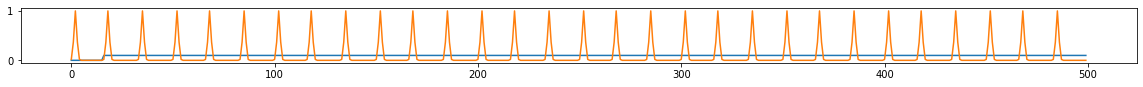

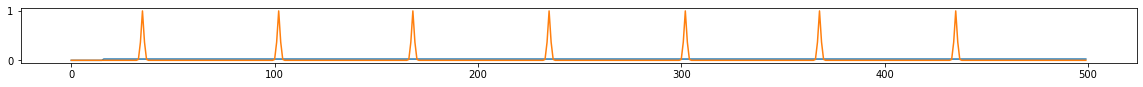

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.69it/s  0.0403                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

1 of 60
TRAIN LOSS: 0.038064385688788185
VAL LOSS: 0.03882022872567177


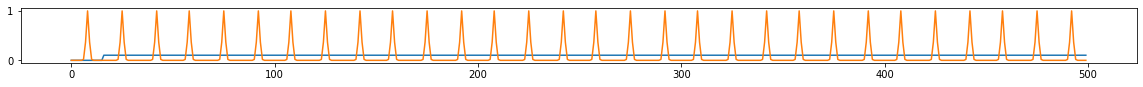

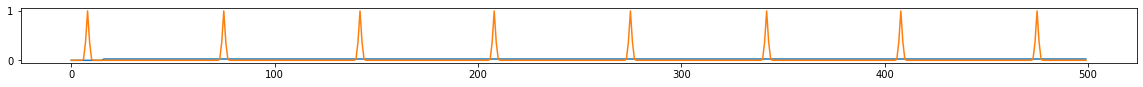

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.94it/s  0.0409                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

2 of 60
TRAIN LOSS: 0.03804145974887384
VAL LOSS: 0.03884643204510212


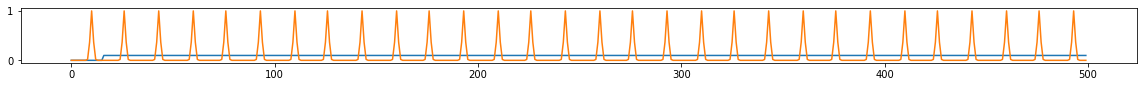

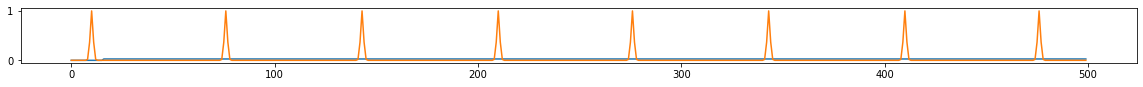

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.87it/s  0.0381                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

3 of 60
TRAIN LOSS: 0.03793029618021604
VAL LOSS: 0.039044301584362985


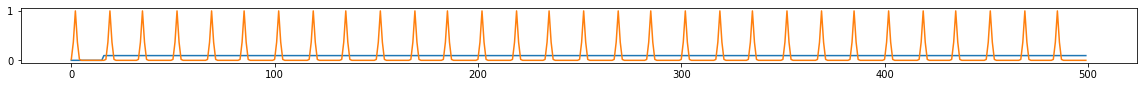

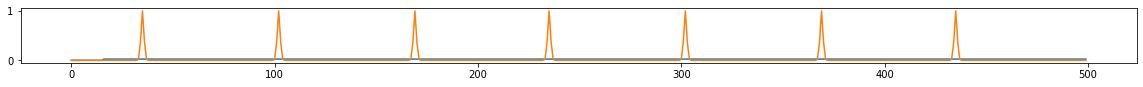

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.78it/s  0.0382                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

4 of 60
TRAIN LOSS: 0.03793410342690107
VAL LOSS: 0.039105919748544694


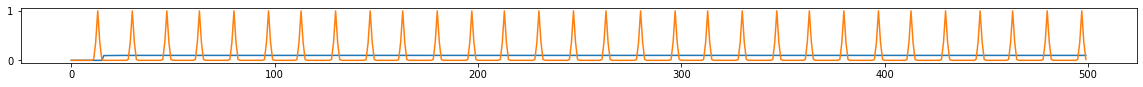

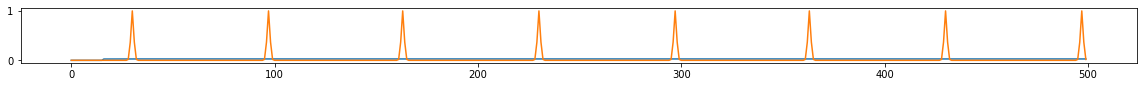

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.75it/s  0.0357                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

5 of 60
TRAIN LOSS: 0.03767254163284559
VAL LOSS: 0.03777695670723915


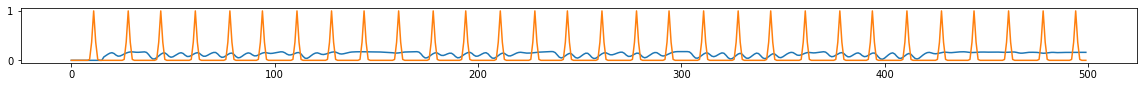

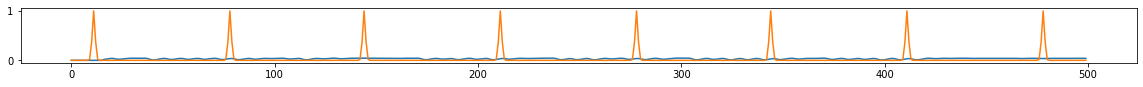

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.77it/s  0.0335                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

6 of 60
TRAIN LOSS: 0.036078753906327324
VAL LOSS: 0.035698522627353665


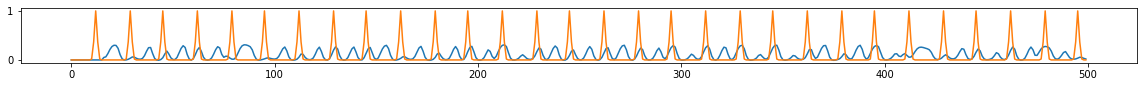

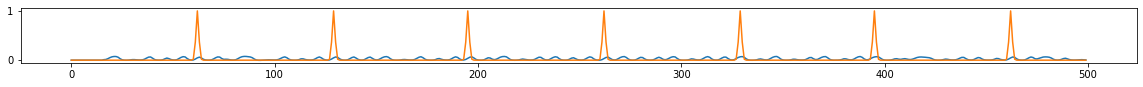

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.64it/s  0.0324                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

7 of 60
TRAIN LOSS: 0.0344498965989899
VAL LOSS: 0.03380037285387516


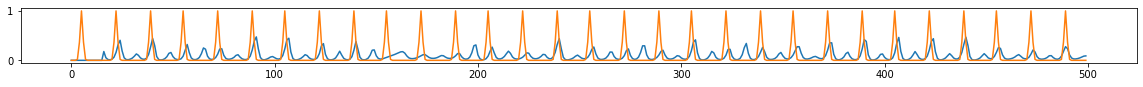

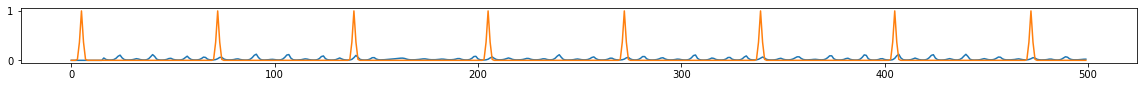

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.96it/s  0.0267                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

8 of 60
TRAIN LOSS: 0.031695922735977815
VAL LOSS: 0.031403764709830286


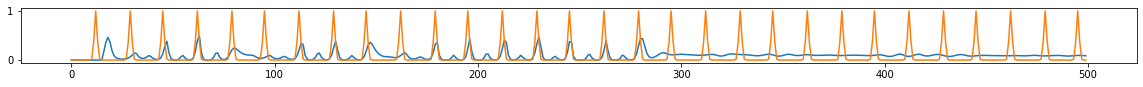

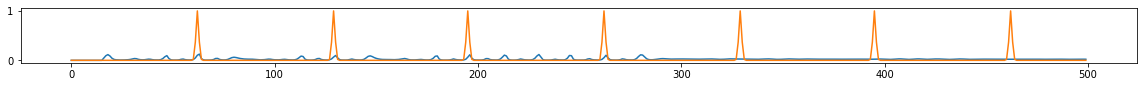

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.56it/s  0.0317                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

9 of 60
TRAIN LOSS: 0.03123076572208791
VAL LOSS: 0.031125216744840145


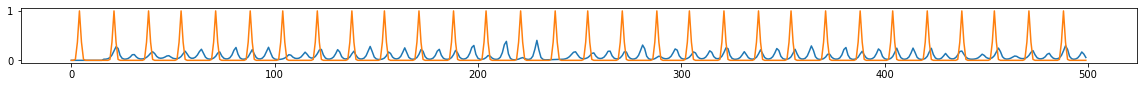

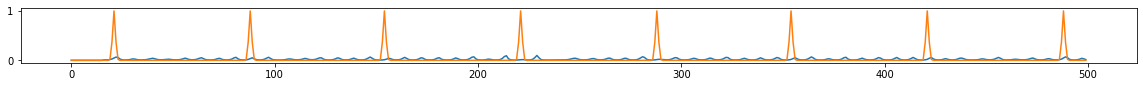

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.85it/s  0.0305                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

10 of 60
TRAIN LOSS: 0.030453078046038345
VAL LOSS: 0.029947396740317343


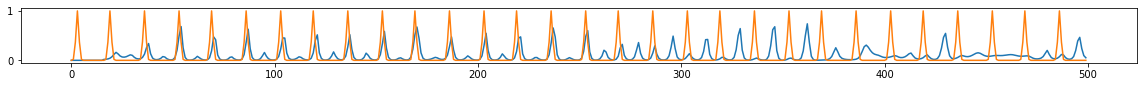

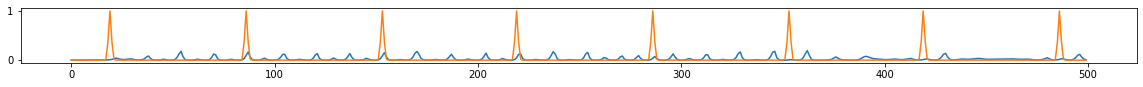

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  7.03it/s  0.0314                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

11 of 60
TRAIN LOSS: 0.03257643335775749
VAL LOSS: 0.03077130764722824


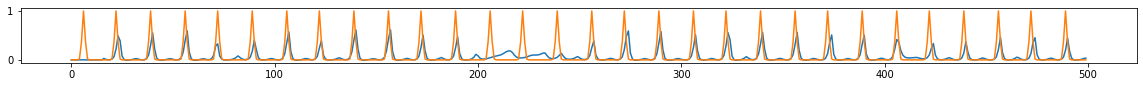

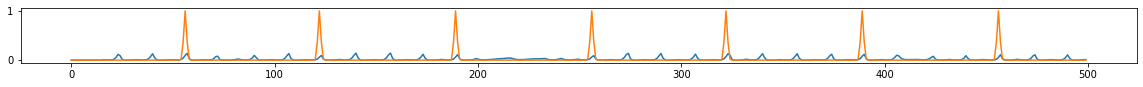

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.75it/s  0.0300                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

12 of 60
TRAIN LOSS: 0.028998260914876655
VAL LOSS: 0.029756969399750234


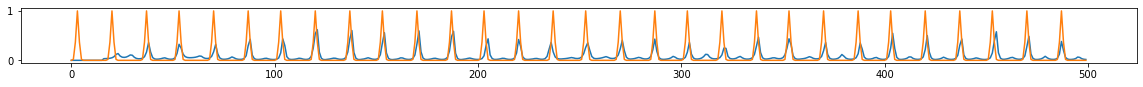

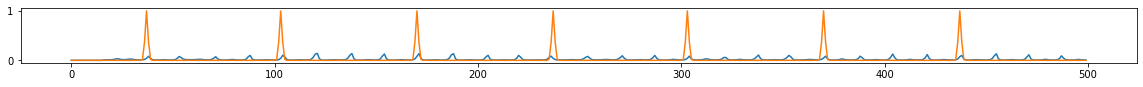

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.88it/s  0.0313                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

13 of 60
TRAIN LOSS: 0.02886074101804076
VAL LOSS: 0.028334989957511426


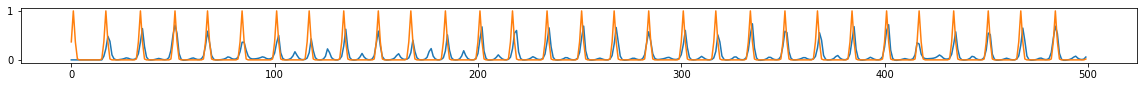

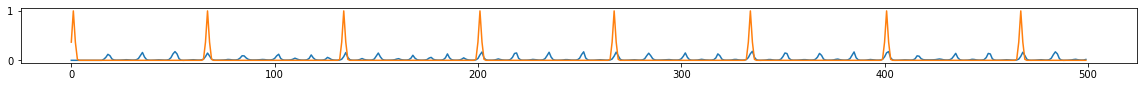

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.65it/s  0.0259                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

14 of 60
TRAIN LOSS: 0.02779342551287767
VAL LOSS: 0.027432772517204284


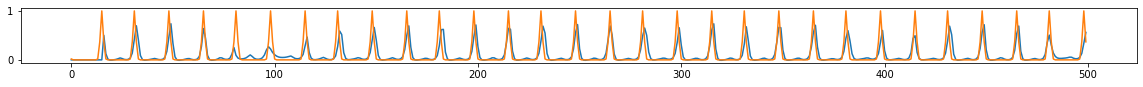

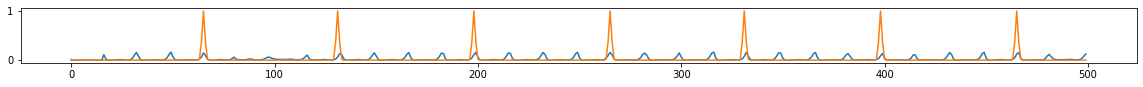

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.77it/s  0.0287                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

15 of 60
TRAIN LOSS: 0.02662621866408232
VAL LOSS: 0.027782083302736283


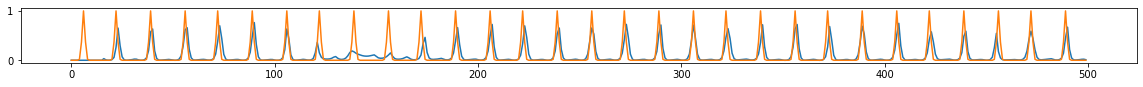

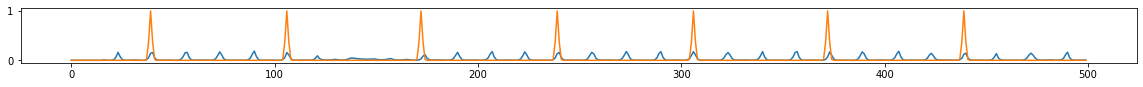

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.57it/s  0.0312                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

16 of 60
TRAIN LOSS: 0.02661935954883292
VAL LOSS: 0.025593060068786144


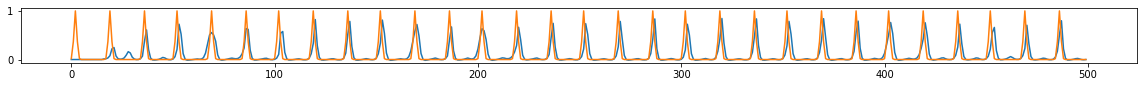

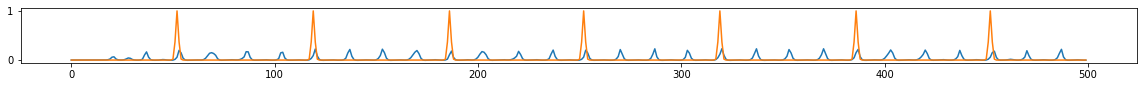

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.51it/s  0.0323                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

17 of 60
TRAIN LOSS: 0.026897728443145752
VAL LOSS: 0.026862415485084057


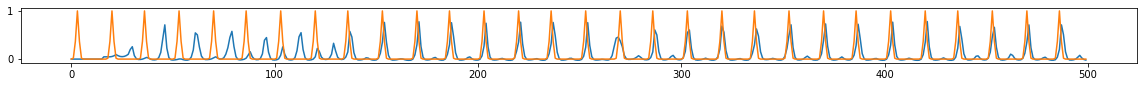

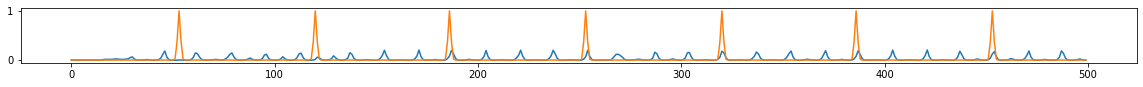

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.88it/s  0.0382                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

18 of 60
TRAIN LOSS: 0.03092551452888025
VAL LOSS: 0.038896944373846054


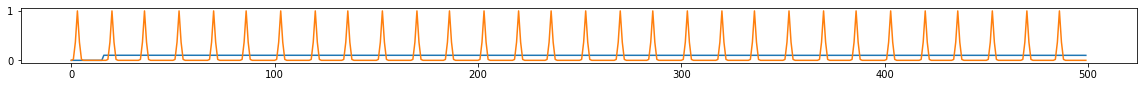

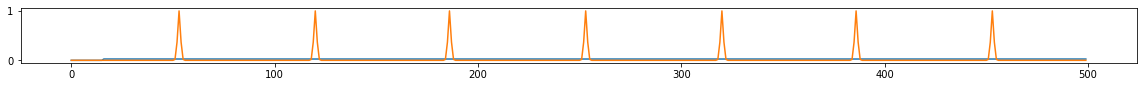

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.94it/s  0.0360                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

19 of 60
TRAIN LOSS: 0.037955224816058133
VAL LOSS: 0.03892002142965793


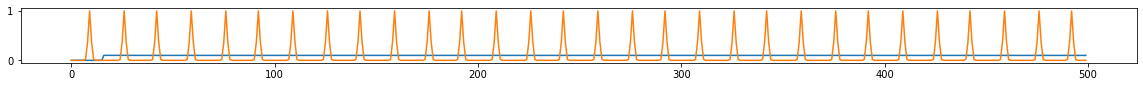

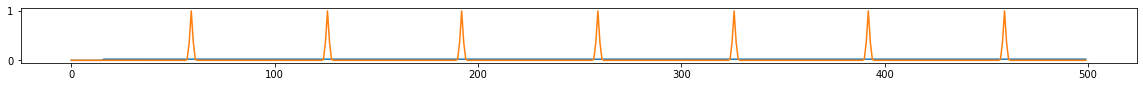

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.98it/s  0.0358                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

20 of 60
TRAIN LOSS: 0.0378591075942323
VAL LOSS: 0.03902025185525417


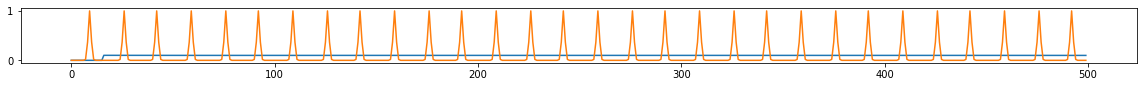

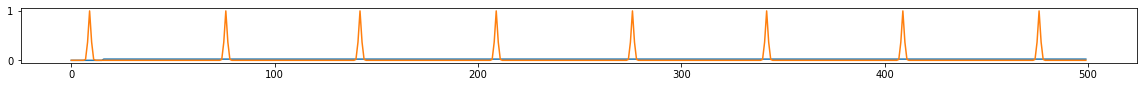

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.72it/s  0.0371                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

21 of 60
TRAIN LOSS: 0.03798776049468968
VAL LOSS: 0.039016857743263245


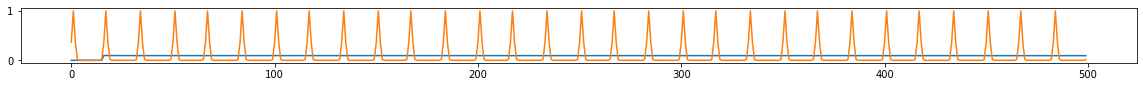

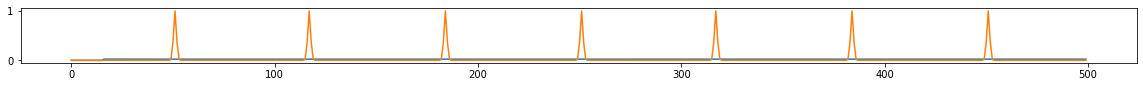

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.18it/s  0.0408                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

22 of 60
TRAIN LOSS: 0.03801859593069231
VAL LOSS: 0.03896907195448875


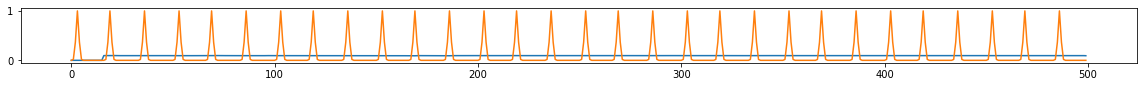

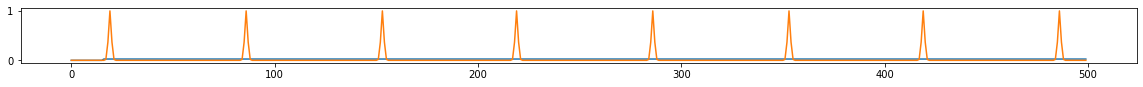

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.64it/s  0.0373                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

23 of 60
TRAIN LOSS: 0.03775890221869623
VAL LOSS: 0.038831860199570654


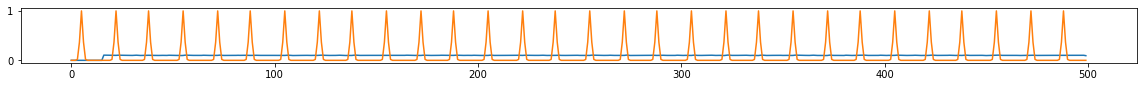

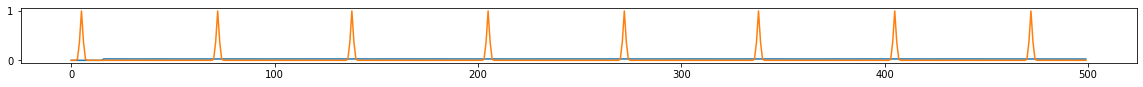

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.72it/s  0.0320                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

24 of 60
TRAIN LOSS: 0.03632457035820227
VAL LOSS: 0.034325598180294035


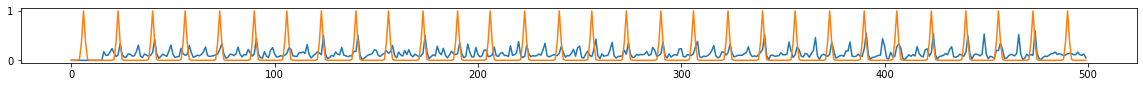

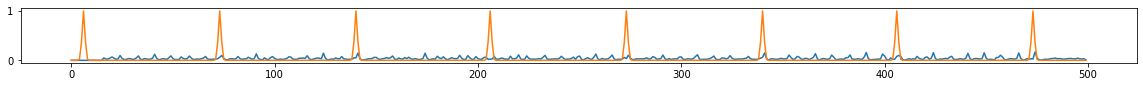

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.74it/s  0.0291                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

25 of 60
TRAIN LOSS: 0.03240012619140986
VAL LOSS: 0.03257324732840061


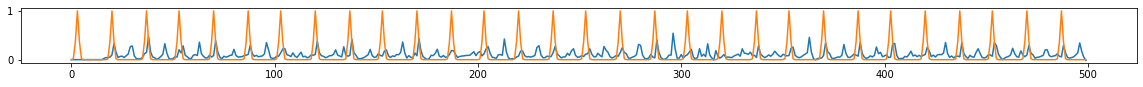

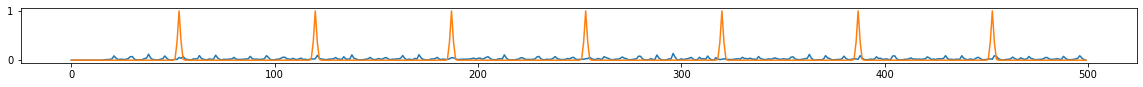

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.74it/s  0.0313                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

26 of 60
TRAIN LOSS: 0.03131404926849378
VAL LOSS: 0.03175085540860891


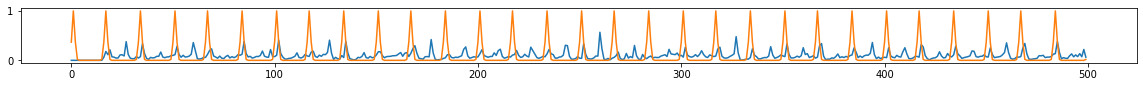

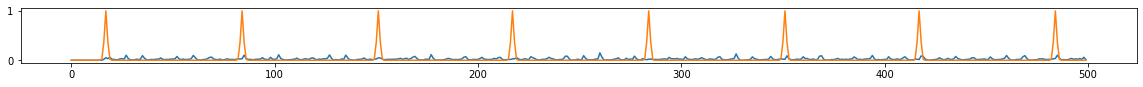

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.84it/s  0.0319                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

27 of 60
TRAIN LOSS: 0.03054496318705984
VAL LOSS: 0.03176042623817921


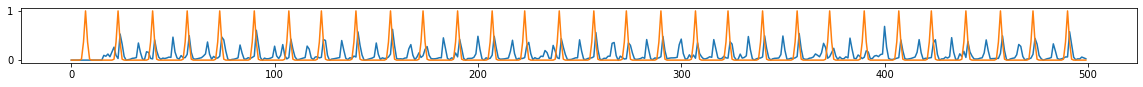

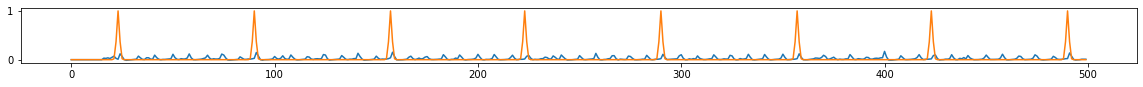

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.36it/s  0.0318                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

28 of 60
TRAIN LOSS: 0.029425983543734293
VAL LOSS: 0.02894699517637491


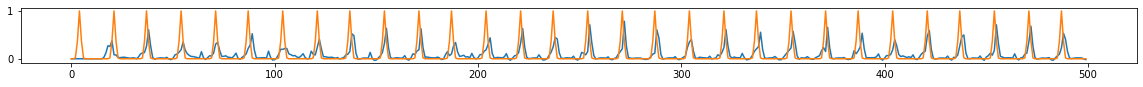

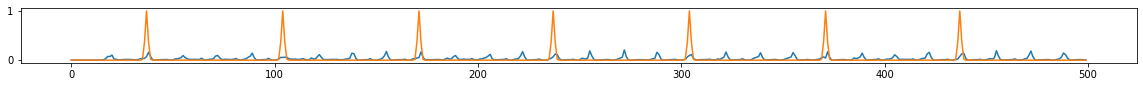

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.73it/s  0.0262                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

29 of 60
TRAIN LOSS: 0.02825872746069689
VAL LOSS: 0.028058282285928726


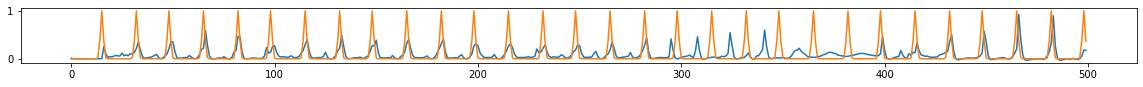

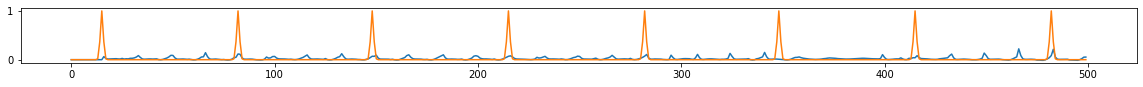

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.84it/s  0.0290                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

30 of 60
TRAIN LOSS: 0.02788952607158068
VAL LOSS: 0.028614312410354614


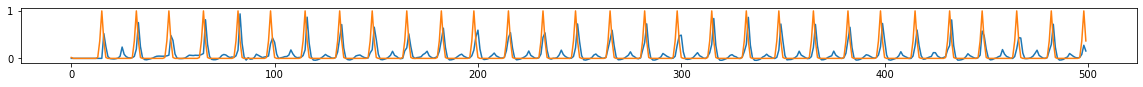

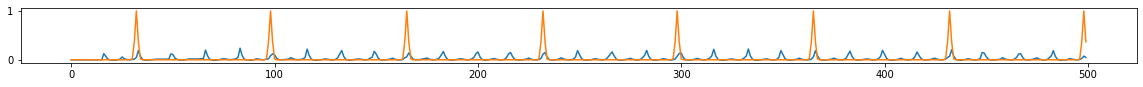

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.89it/s  0.0320                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

31 of 60
TRAIN LOSS: 0.03243581281119102
VAL LOSS: 0.03308230973780155


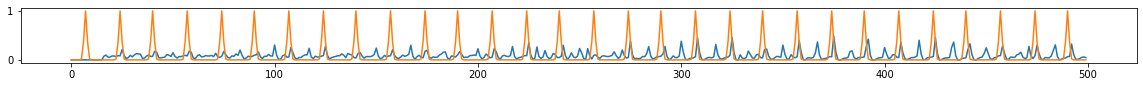

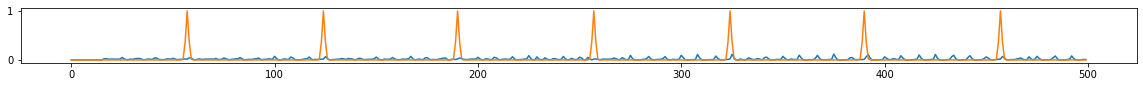

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.93it/s  0.0303                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

32 of 60
TRAIN LOSS: 0.03148567500348027
VAL LOSS: 0.03146851155906916


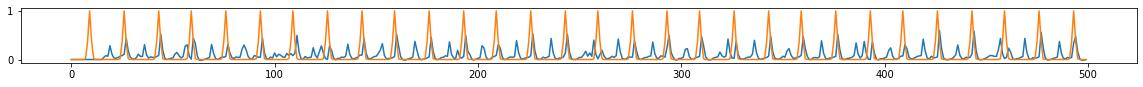

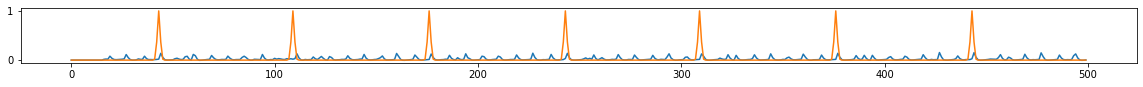

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.66it/s  0.0285                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

33 of 60
TRAIN LOSS: 0.03034089133143425
VAL LOSS: 0.03086707890033722


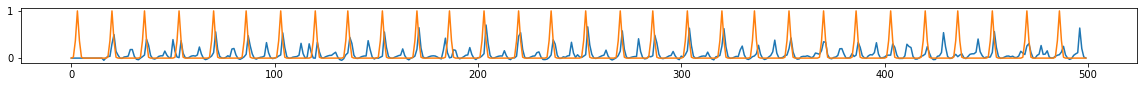

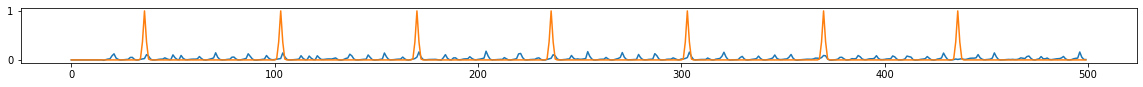

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.88it/s  0.0282                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

34 of 60
TRAIN LOSS: 0.028983598826704798
VAL LOSS: 0.02878669071942568


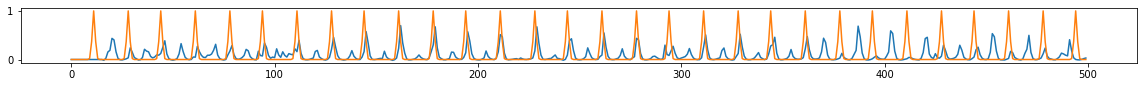

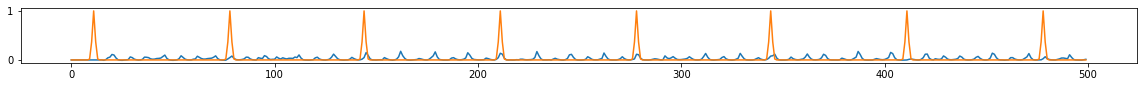

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.94it/s  0.0299                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

35 of 60
TRAIN LOSS: 0.027910203798799903
VAL LOSS: 0.028630533441901206


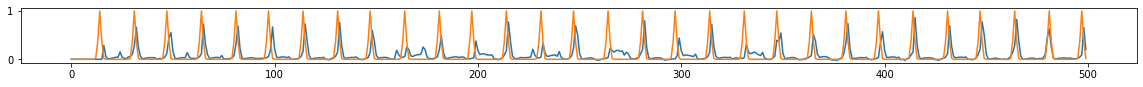

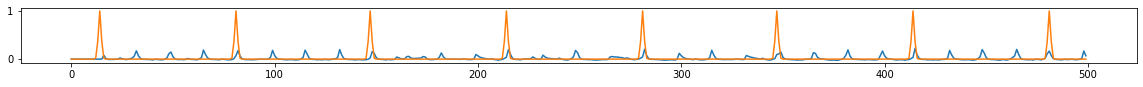

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.74it/s  0.0274                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

36 of 60
TRAIN LOSS: 0.027470683930693445
VAL LOSS: 0.028805176727473736


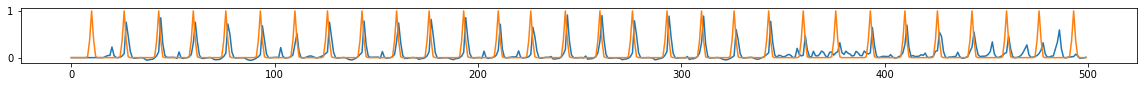

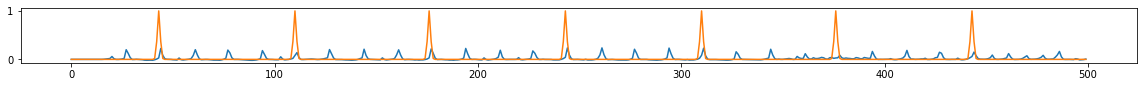

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.85it/s  0.0272                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

37 of 60
TRAIN LOSS: 0.02686996732813281
VAL LOSS: 0.02704168241471052


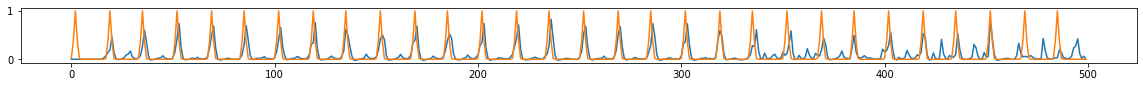

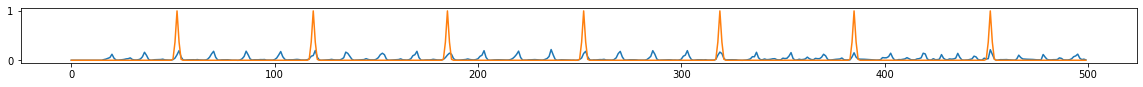

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.80it/s  0.0241                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

38 of 60
TRAIN LOSS: 0.025964064070501842
VAL LOSS: 0.026484635099768637


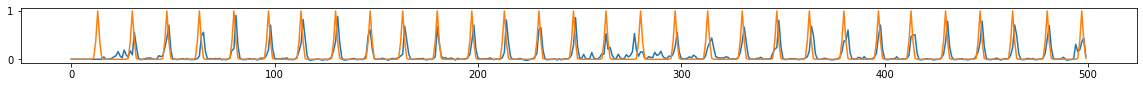

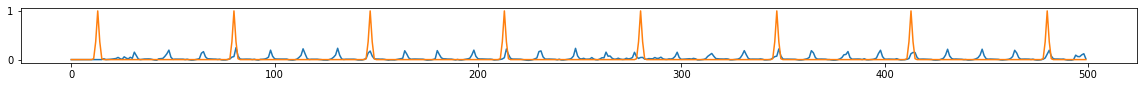

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.69it/s  0.0246                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

39 of 60
TRAIN LOSS: 0.02603303676320089
VAL LOSS: 0.025414515659213065


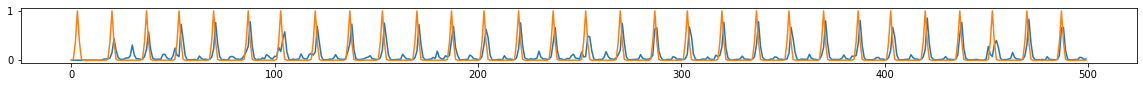

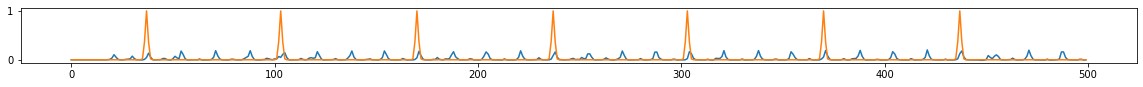

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  7.03it/s  0.0223                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

40 of 60
TRAIN LOSS: 0.025704495659148372
VAL LOSS: 0.02538933027535677


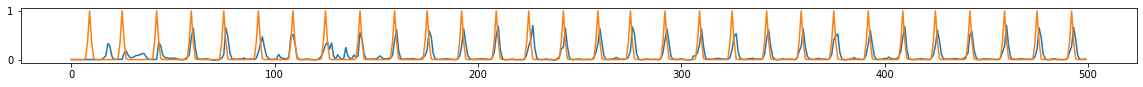

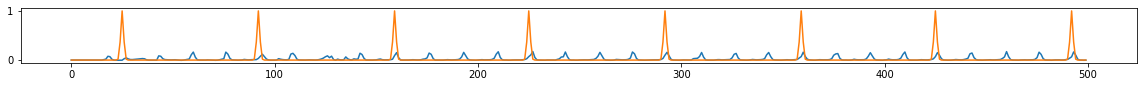

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.65it/s  0.0220                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

41 of 60
TRAIN LOSS: 0.025192805893115094
VAL LOSS: 0.02597787417471409


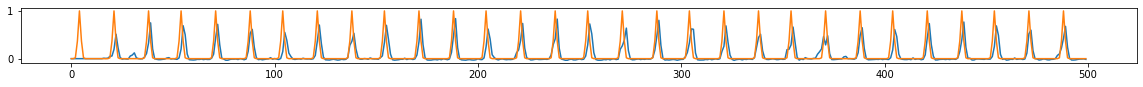

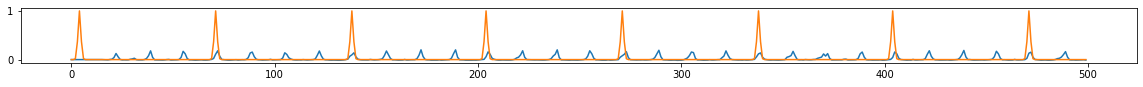

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.66it/s  0.0315                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

42 of 60
TRAIN LOSS: 0.025288519222994108
VAL LOSS: 0.029067790508270262


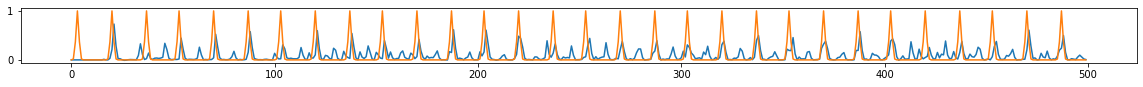

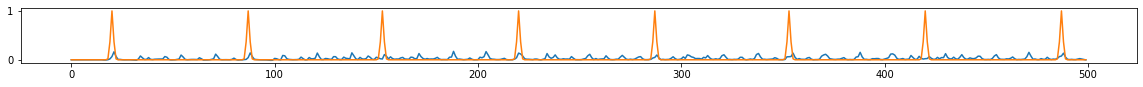

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.26it/s  0.0257                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

43 of 60
TRAIN LOSS: 0.029292282824580733
VAL LOSS: 0.028492443822324277


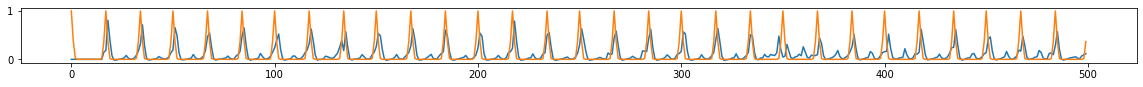

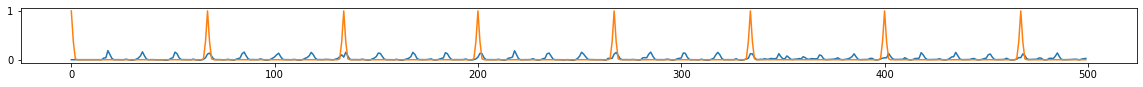

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.42it/s  0.0307                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

44 of 60
TRAIN LOSS: 0.029021342813565925
VAL LOSS: 0.031851515360176566


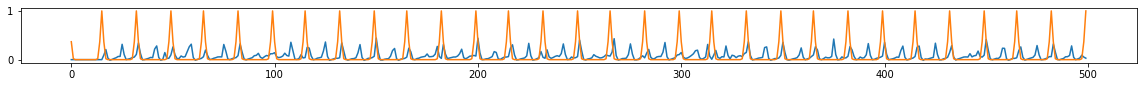

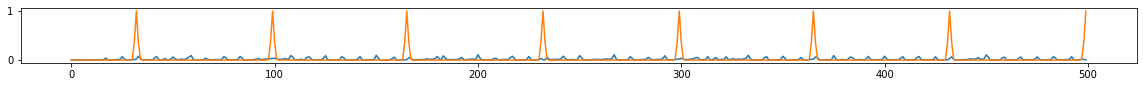

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.52it/s  0.0276                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

45 of 60
TRAIN LOSS: 0.029883176591750736
VAL LOSS: 0.029636455699801445


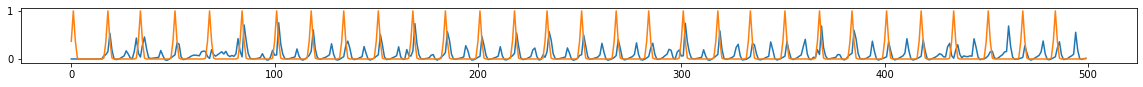

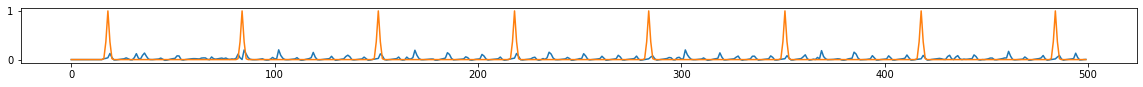

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.73it/s  0.0323                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

46 of 60
TRAIN LOSS: 0.02842539850924466
VAL LOSS: 0.028201895579695702


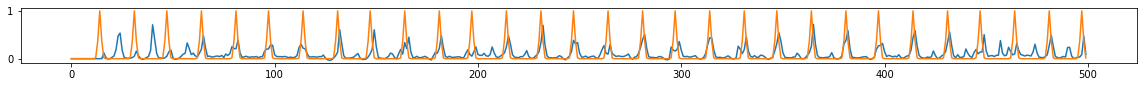

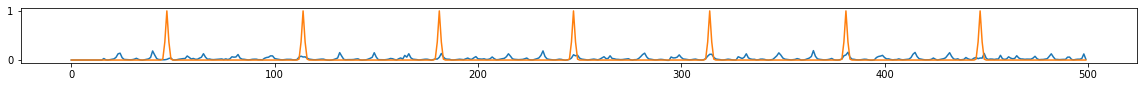

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.63it/s  0.0284                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

47 of 60
TRAIN LOSS: 0.028633767336204246
VAL LOSS: 0.028982095792889594


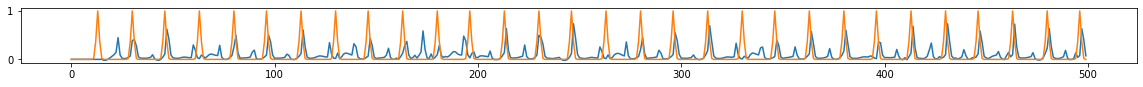

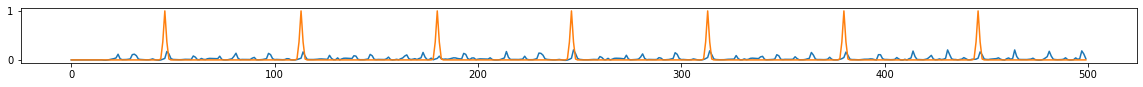

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.69it/s  0.0287                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

48 of 60
TRAIN LOSS: 0.02810059810006941
VAL LOSS: 0.028300649859011172


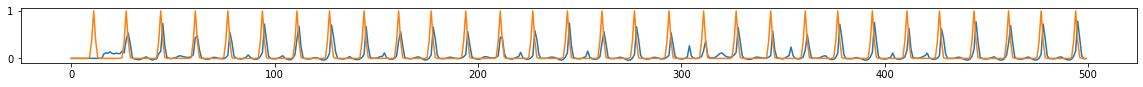

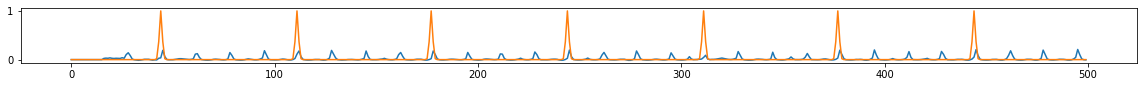

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.51it/s  0.0258                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

49 of 60
TRAIN LOSS: 0.027213112073572906
VAL LOSS: 0.027458802238106726


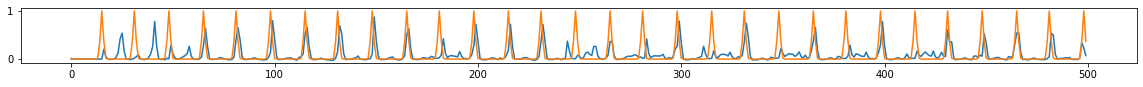

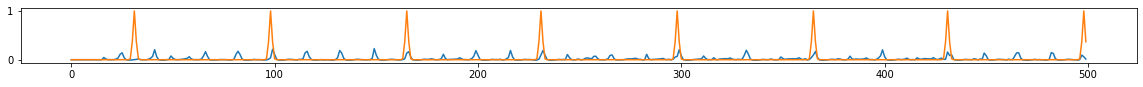

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.64it/s  0.0280                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

50 of 60
TRAIN LOSS: 0.026580265144238602
VAL LOSS: 0.02613336741924286


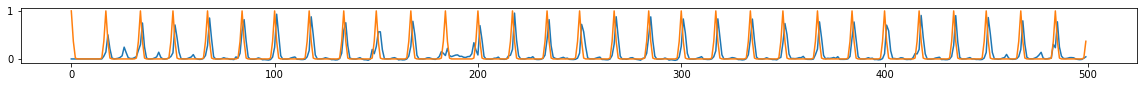

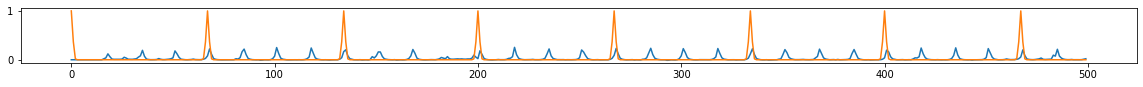

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.69it/s  0.0278                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

51 of 60
TRAIN LOSS: 0.026495012832251755
VAL LOSS: 0.027153381332755088


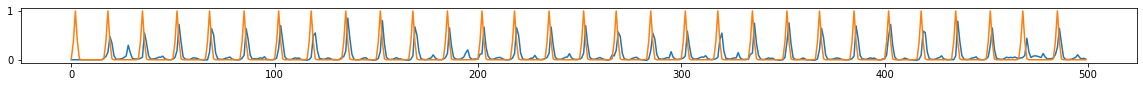

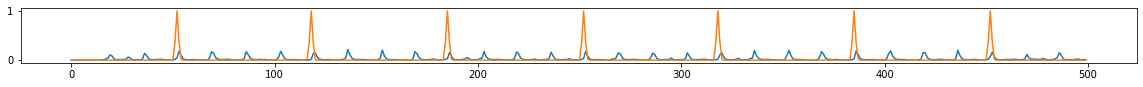

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.54it/s  0.0238                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

52 of 60
TRAIN LOSS: 0.0263053596623846
VAL LOSS: 0.026399817690253256


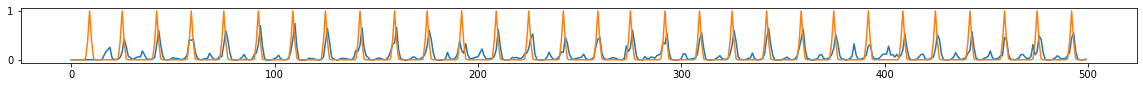

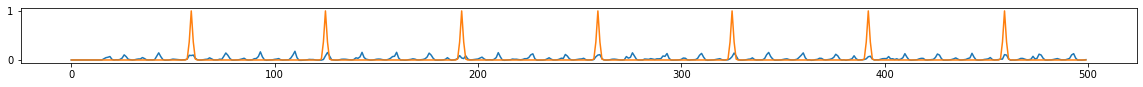

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.69it/s  0.0279                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

53 of 60
TRAIN LOSS: 0.02590977309926136
VAL LOSS: 0.02782799918204546


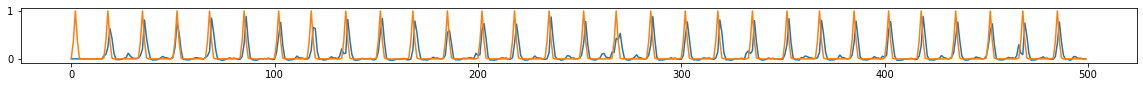

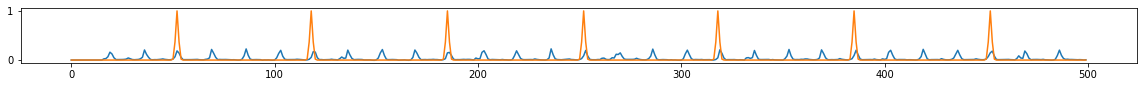

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.90it/s  0.0301                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

54 of 60
TRAIN LOSS: 0.026946041984735308
VAL LOSS: 0.026375160738825797


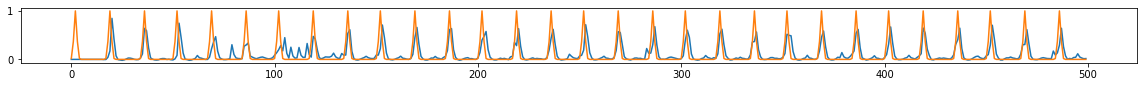

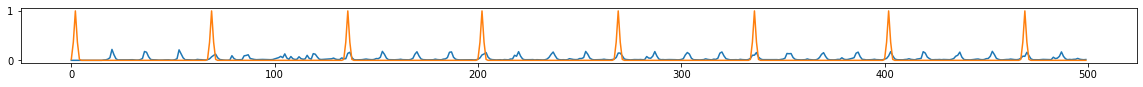

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.85it/s  0.0250                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

55 of 60
TRAIN LOSS: 0.02533168295348013
VAL LOSS: 0.024975670129060747


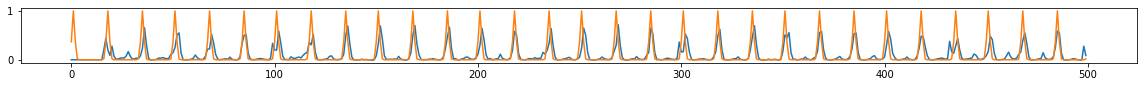

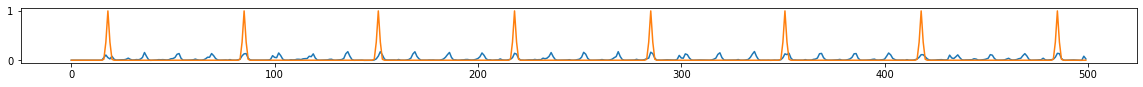

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.70it/s  0.0282                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

56 of 60
TRAIN LOSS: 0.02511716664240167
VAL LOSS: 0.026815233938395976


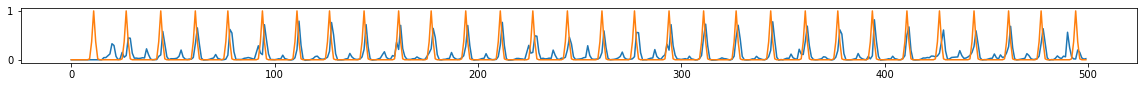

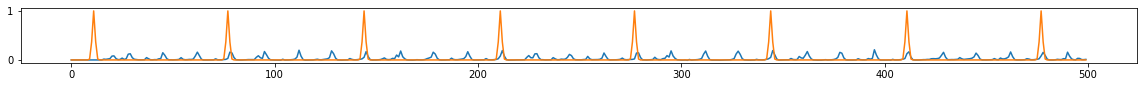

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.73it/s  0.0233                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

57 of 60
TRAIN LOSS: 0.025093652358328975
VAL LOSS: 0.024974687956273556


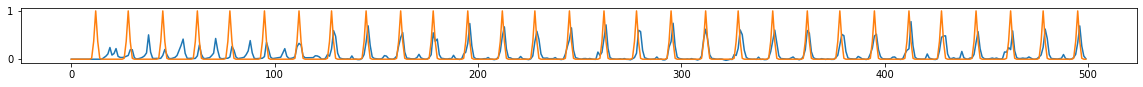

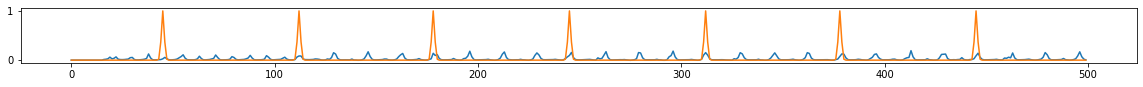

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  6.79it/s  0.0210                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

58 of 60
TRAIN LOSS: 0.025020325052979832
VAL LOSS: 0.02641706559807062


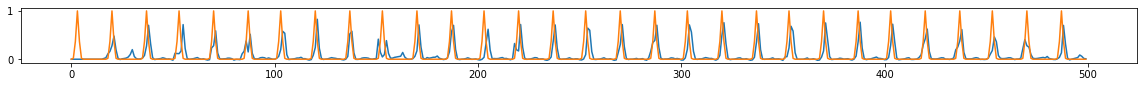

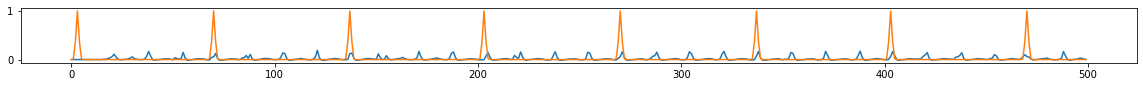

 Iters    Elapsed Time      Speed     loss                                      
 37/37  00:00:05<00:00:00  7.05it/s  0.0218                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

59 of 60
TRAIN LOSS: 0.024461774860282202
VAL LOSS: 0.0245344340801239


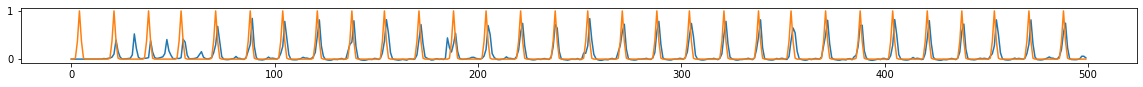

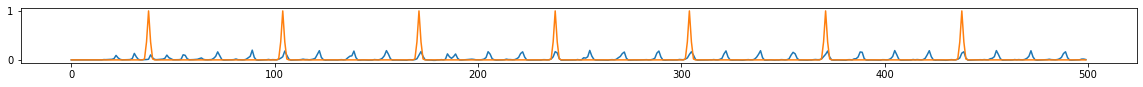

362.95089054107666 secs


In [106]:
plt.rcParams["figure.figsize"] = (20,1)
start = time.time()

train()

end = time.time()
print(end - start, 'secs')

In [ ]:
plt.rcParams["figure.figsize"] = (20,1)
start = time.time()

train()

end = time.time()
print(end - start, 'secs')

In [113]:
torch.save(model.state_dict(), model_path)